原作者：Arun Godwin Patel
<p>[原文链接](https://www.kaggle.com/agodwinp/deep-sea-dive-into-top-10-survival-guide)</p>

# 1. 
## Import packages

In [1]:
# This first set of packages include Pandas, for data manipulation, numpy for mathematical computation
# and matplotlib & seaborn, for visualisation.
import pandas as pd
import numpy as np
from numpy import sort
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

# Next, these packages are from the scikit-learn library, including the algorithms I plan to use.
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
print('Algorithm packages imported!')

# These packages are also from scikit-learn, but these will be used for model selection and cross validation.
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
print('Model Selection packages imported!')

# Once again, these are from scikit-learn, but these will be used to assist me during feature reduction.
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
print('Feature Reduction packages imported!')

# Finally, a metrics package from scikit-learn to be used when comparing the results of the cross validated models. 
from sklearn import metrics
print('Cross Validation Metrics packages imported!')

# Set visualisation colours
mycols = ["#76CDE9", "#FFE178", "#9CE995", "#E97A70"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print('Future warning will be ignored!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!
Algorithm packages imported!
Model Selection packages imported!
Feature Reduction packages imported!
Cross Validation Metrics packages imported!
My colours are ready! :)
Future warning will be ignored!


# 2. 
## 数据载入

- Pandas对于我们处理训练数据、测试数据很有帮助
- 我们会把这些数据集结合起来做一些共同的操作

In [2]:
# Read the raw training and test data into DataFrames.
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

# Append the test dataset onto train to allow for easier feature engineering across both datasets.
full = raw_train.append(raw_test, ignore_index=True)

print('Datasets \nfull: ', full.shape, '\ntrain: ', raw_train.shape, '\ntest: ', raw_test.shape)
full.head(3)

Datasets 
full:  (1309, 12) 
train:  (891, 12) 
test:  (418, 11)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282


- 如上，有891条训练数据，418条测试数据。 由于数据集很小，需要用一些手段来增强模型的鲁棒性。

- 12个属性字段:
    - **Age** - 乘客年龄
    - **Cabin** - 乘客所在的客舱号，若为 NaN, 意味着这些乘客由于票价的原因没有被安排客舱
    - **Embarked** - 登船口 (S = Southampton, C = Cherbourg, Q = Queenstown)
    - **Fare** - 票价
    - **Name** - 乘客的全名
    - **Parch** - 与乘客搭乘的父母和子女的数量
    - **PassengerId** - 每个乘客的标识号码
    - **Pclass** - 船票等级 (1 = 1st class, 2 = 2nd class, 3 = 3rd class)
    - **Sex** - 乘客性别
    - **SibSp** - 与乘客搭乘的兄弟姐妹和配偶的人数
    - **Survived** - 是否幸存(1 = Survived, 0 = did not survive)
    - **Ticket** - 船票编号
    
 
 ## 注意:

**Pclass** 可以被视为社会经济地位的代表:
- 1st = 高级
- 2nd = 中级
- 3rd = 低级

**Age**: 如果乘客少于1岁，年龄就是分数。 如果估计年龄，它是xx.5的形式

**SibSp & Parch**: 这两列代表了家庭关系，这些家庭关系的定义如下:
- Sibling = 兄弟，姐妹，继兄弟，继母
- Spouse = 丈夫，妻子（情妇和未婚妻被忽略）
- Parent = 母亲，父亲
- Child = 女儿，儿子，继女，继子
- 有些孩子只带着保姆出行，因此Parch = 0

***

# 3. 
## 特征分析
### 3.1 - 识别并处理缺失值

***为什么缺失数据很重要***

首先，一些算法不适用于有缺失值的数据。为了应用这些算法，我们需要用合理的方法处理这些数据。

**对于缺失数据可以这么做**:
- 删除有缺失值的整行数据
- 填充缺失的条目

由于我们的训练数据非常少，因此希望保留尽可能多的数据，得到更好的训练效果。 这意味着接下来我们会对缺失数据做补全。


缺失值有很多含义:
- **数据集生成过程中产生的错误**。 这可能是人为错误，或是数据的来源的机械错误。 
- 在某些情况下缺失值可能意味着“零”。 在这种情况下，它可以被替换为0。
- 缺失值也可能意味着没有包含信息。因此，零填充不一定是合适的。

必须小心谨慎的处理缺失值，因为你处理的过程是基于自己的假设。

为了决定如何填充缺失数据，我们先来看看哪些列缺少了数据。

In [3]:
full.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

 **Age**, **Cabin**, **Embarked** 和 **Fare** 缺失了数据。
 **Survived** 缺失的值是测试集部分。

下表列出了一些描述性统计数据，以帮助我们填补缺失值。

In [4]:
full.describe(include='all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Connolly, Miss. Kate",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


下面的相关矩阵可以为我们提供关于如何用缺失值填充数字列的指导

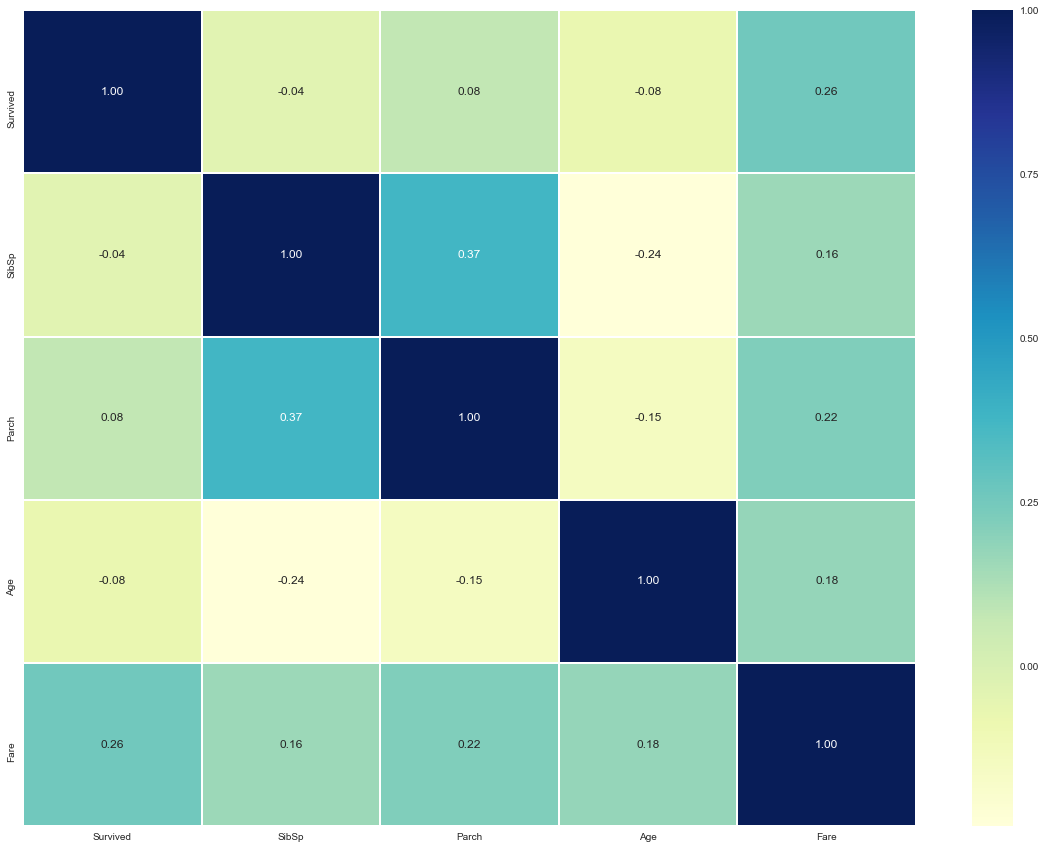

In [5]:
# Correlation matrix between numerical values (SibSp, Parch, Age and Fare) with Survived 
plt.subplots(figsize=(20, 15))
g = sns.heatmap(full[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "YlGnBu", linewidths = 1)

### 3.1.1 - Age

从上述数据可以看出:
- 平均年龄大约29
- 年龄的标准差约为14
- 最小年龄约0.17
- 最大年龄80

通过相关性分析，年龄和以下因素的相关性较高:
- **票价**
- **父母子女数量**
- **配偶孩子数量**

因此，我们将使用这些数据来计算Age的缺失值。 根据这3个特征，我们将根据相似行的平均年龄来计算这些值。 如果没有相似的行，缺少的值用数据集的平均年龄填充。

In [6]:
# Creates a list of all the rows with missing values for age, ordered by Index
missing_age = list(full["Age"][full["Age"].isnull()].index)

# Using a for loop to iterate through the list of missing values, and filling each entry with the imputed value
for i in missing_age:
    age_med = full["Age"].median() # median age for entire dataset
    age_pred = full["Age"][((full['SibSp'] == full.iloc[i]["SibSp"]) & (full['Parch'] == full.iloc[i]["Parch"]) & (full['Pclass'] == full.iloc[i]["Pclass"]))].median() # median age of similar passengers
    if not np.isnan(age_pred):
        full['Age'].iloc[i] = age_pred # if there are similar passengers, fill with predicted median
    else:
        full['Age'].iloc[i] = age_med # otherwise, fill with median of entire dataset

print('Number of missing values for Age: ', full['Age'].isnull().sum())

D:\Anaconda2\envs\py3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Number of missing values for Age:  0


**大多数统计模型都依赖于正态分布**, 该分布是对称的，并具有特征钟形。

机器学习算法不需要事先知道它将使用的数据分布的类型，而是直接从用于训练的数据中学习。 我们使用基于距离度量的K-最近邻算法。 这对提供的数值范围非常敏感。 因此，为了使算法更快地收敛或提供更精确的解决方案，我已经研究了分布。

即使转换分布对于机器学习算法正常工作而言不是必需的，但由于以下原因，它仍然是有益的：

- 使 **代价函数最小化** 对于误差预测更有效
- 使该策略 **收敛的更快更好**

查看下面的分布图，我们可以看到它相当遵循正态分布，所以我们不需要重新缩放或转换此列。

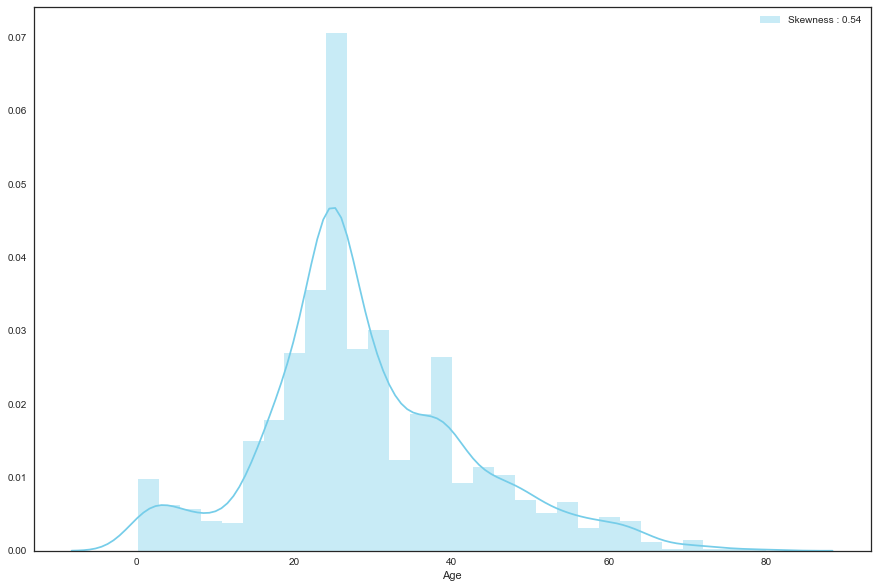

In [7]:
plt.subplots(figsize=(15, 10))
g = sns.distplot(full["Age"], color="#76CDE9", label="Skewness : %.2f"%(full["Age"].skew()))
g = g.legend(loc="best");

### 3.1.2 - 客舱

客舱是个有趣的特征，它蕴含着很多信息:
- 票价
- 社会经济地位
- 乘客位于甲板，可能更有利于逃生

然而，我们缺失很多客舱值，这意味着现在它是不利于我们的预测。

想准确的预测客舱是不可能的。 首先，因为这个信息是未知的，还需要很长时间来尝试找出每个乘客可能的客舱。

T这时候需要我们自己去权衡. 我采取的策略是 **用'X'填充缺失**, 表示乘客并没被分配客舱。 

对于现有的值，我们有很多类别。 小屋的每个值都包含一个字母，后跟一个数字，如下所示。 因此，我将简单分析客舱的字母，以便创建更简洁的类别。

In [8]:
# Crosstab to show the number of unique categories within the Cabin feature
pd.crosstab(full['Sex'], full['Cabin'])

Cabin,A10,A11,A14,A16,A18,A19,A20,A21,A23,A24,...,F E57,F E69,F G63,F G73,F2,F33,F38,F4,G6,T
Sex,,,,,,,,,,,,,,,,,,,,,
female,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,4,0,3,5,0
male,1,0,1,0,1,1,1,1,1,1,...,1,0,2,2,4,0,1,1,0,1


In [9]:
# Cabin
full["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in full['Cabin'] ])
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,X,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,X,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,X,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


### 3.1.3 - 登船口

从上面的缺失值表中，我们可以看到，我们只有2个缺少的入口值。 因此，由于我们可以从统计数据中得知“南安普敦”是数据集中最频繁登船的港口，所以**我将用“S”填补此列的缺失值。**

In [10]:
#  Filling the missing values in Embarked with 'S'
full['Embarked'].fillna("S", inplace = True)

# full = pd.get_dummies(full, columns = ["Cabin"], prefix="Cabin")
print('Number of missing values for Embarked: ', full['Embarked'].isnull().sum())

Number of missing values for Embarked:  0


### 3.1.4 - Fare

与登船口相似，票价具有非常少的缺失值.因此**我将用中位数填补这一列的缺失值。**

In [11]:
# Fill Fare missing values with the median value
full["Fare"] = full["Fare"].fillna(full["Fare"].median())

# full = pd.get_dummies(full, columns = ["Cabin"], prefix="Cabin")
print('Number of missing values for Fare: ', full['Fare'].isnull().sum())

Number of missing values for Fare:  0


现在我来查看这个特征的分布，因为它是除了Age唯一连续数值特征。

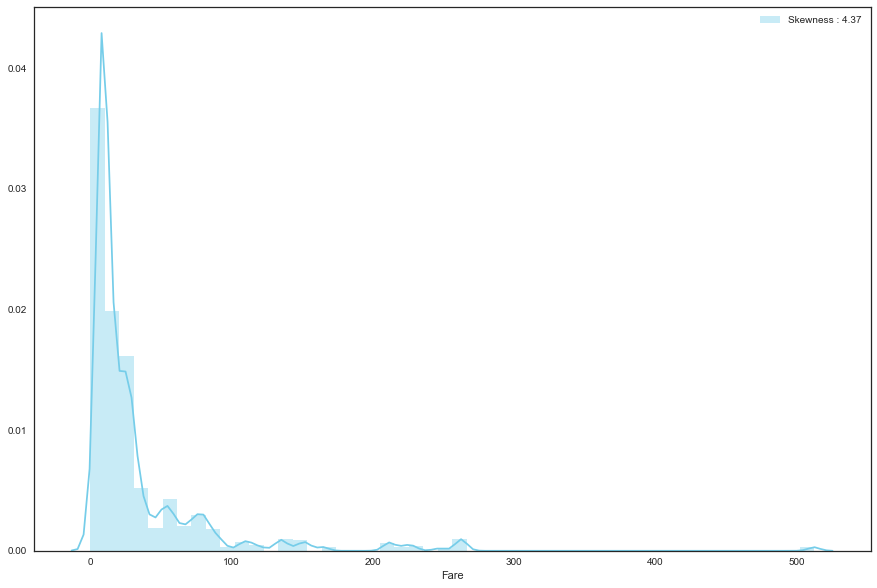

In [12]:
plt.subplots(figsize=(15, 10))
g = sns.distplot(full["Fare"], color="#76CDE9", label="Skewness : %.2f"%(full["Fare"].skew()))
g = g.legend(loc="best");

- 在这里，我们可以看到与我们在Age看到的完全不同的东西。我们可以看到Fare的分布高度**正偏态**，这意味着最常见的值总是小于平均值和中值。从分布图中，我们可以看到大部分值都集中在左边，但是我们有几个大的值是“拖尾”分布。

- 这也可以在描述性统计中看到，我们可以看到下四分位数，中位数和上四分位数相当低，但最大值非常高。

- 当预测值和某些值相对于大多数值太过于极端时，可以应用转换来缩短值之间的距离。所以我们想要改变这个功能来减少任何**极端情况**的权重。

- 当试图最小化错误时，算法因此不会过分关注极值，但会得到一个通用的解决方案。 **对数**转换通常是一个很好的选择，这需要正值，所以这很好。

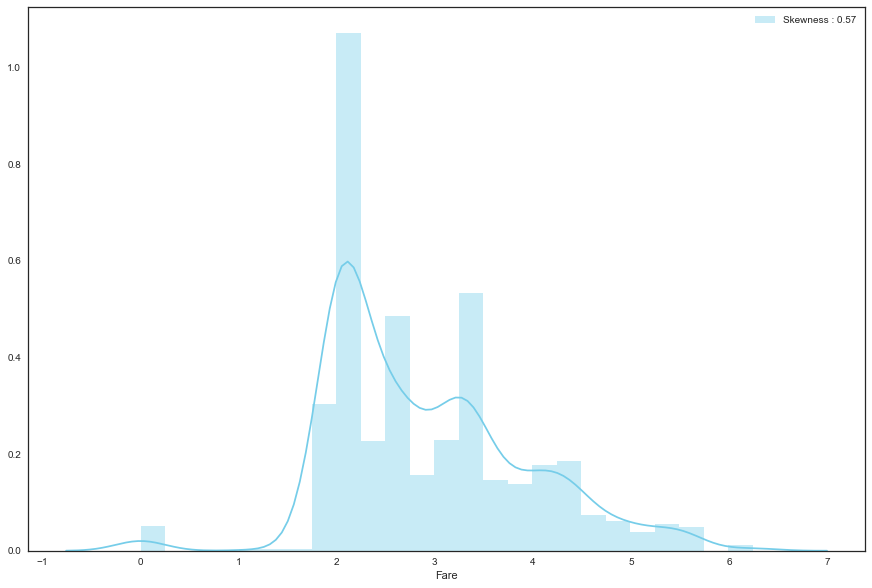

In [13]:
# Apply log to Fare to reduce skewness distribution
full["Fare"] = full["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

plt.subplots(figsize=(15, 10))
g = sns.distplot(full["Fare"], color="#76CDE9", label="Skewness : %.2f"%(full["Fare"].skew()))
g = g.legend(loc="best")

正如你所看到的，现在偏斜度要低得多，现在它更接近正态分布。

### 3.2 - 数值型数据

现在我将分析数据集中的数值特征。 这种探索性分析将帮助我构建下一阶段创建哪些特征的概念，以及是否从这些特征创建分类变量或虚拟变量。

### 3.2.1 - 年龄

- 从上面显示的相关矩阵来看，所有数字特征中只有票价似乎与生存有显着相关性。

- 但是，我们可以从这些现有特征衍生出许多子群体和特征，这些特征可能会显示出一些更显着的相关性。

- 首先，我会观察年龄和幸存的关系。

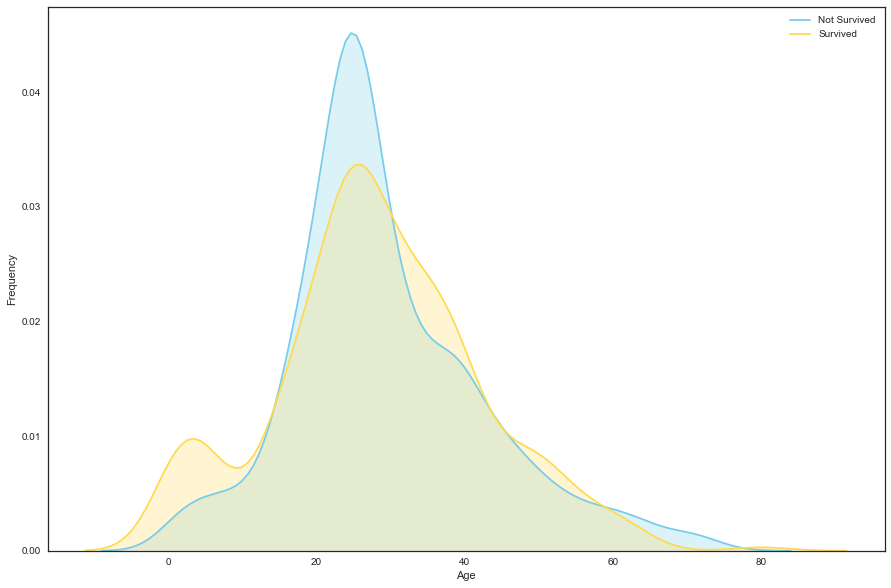

In [14]:
# Age distibution vs Survived
plt.subplots(figsize=(15, 10))
g = sns.kdeplot(full["Age"][(full["Survived"] == 0)], color="#76CDE9",  shade = True)
g = sns.kdeplot(full["Age"][(full["Survived"] == 1)], ax = g, color="#FFDA50", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

- 如前所述，年龄的分布遵循相当的正态分布，并有轻微的拖尾。

- 然而，年龄的分布与幸存和不幸存的乘客略有不同。

- 我们可以看到，一个与年轻乘客有关的高峰，**在10岁以下**，幸存下来。 你也可以看到** 60-80岁**老年人的生存几率较低。 一般来说，年轻乘客比老年人有更大的生存机会。

- 从这个情节中，我们可以说有一些年龄段的乘客有更大或更小的生存机会。
     - **因此，这可能是一个很好的功能，以用来分类到新类别。**
    
### 3.2.2 - 票价

从新对数变换票价功能，我们可以看到该功能具有更低的偏度。 但它并不完全遵循正态分布。 让我们来看看这个功能如何随着生存而改变。

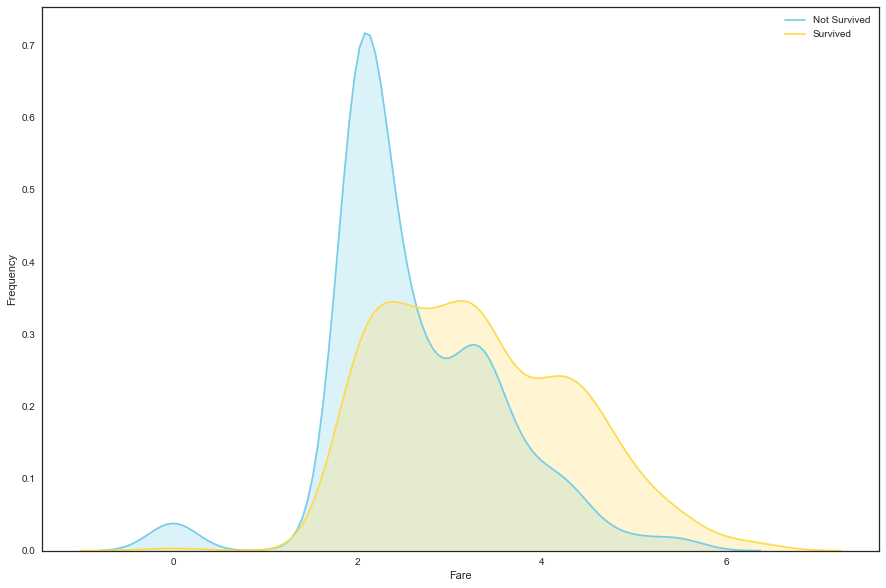

In [15]:
#Age distibution vs Survived
plt.subplots(figsize=(15, 10))
g = sns.kdeplot(full["Fare"][(full["Survived"] == 0)], color="#76CDE9",  shade = True)
g = sns.kdeplot(full["Fare"][(full["Survived"] == 1)], ax = g, color="#FFDA50", shade= True)
g.set_xlabel("Fare")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

- 幸存者与非幸存者之间的票价分布差别很大。 这使我相信票价对生存有着非常重要的影响，正如相关矩阵所支持的。
- 从上述情节我们可以看出，支付较低票价的乘客的生存几率较低。
- 支付中高票价的乘客有更高的生存机会。
     - 因此，**票价本身也是适合分类的好选择。**
    
### 3.2.3 - Parch

- Parch代表与乘客搭乘的父母和儿童的人数。
- 因此，虽然这是一个数字特征，但它是一个离散的特征。 分布图不适合于此，我们将使用因子图来显示每个离散值的生存机会。

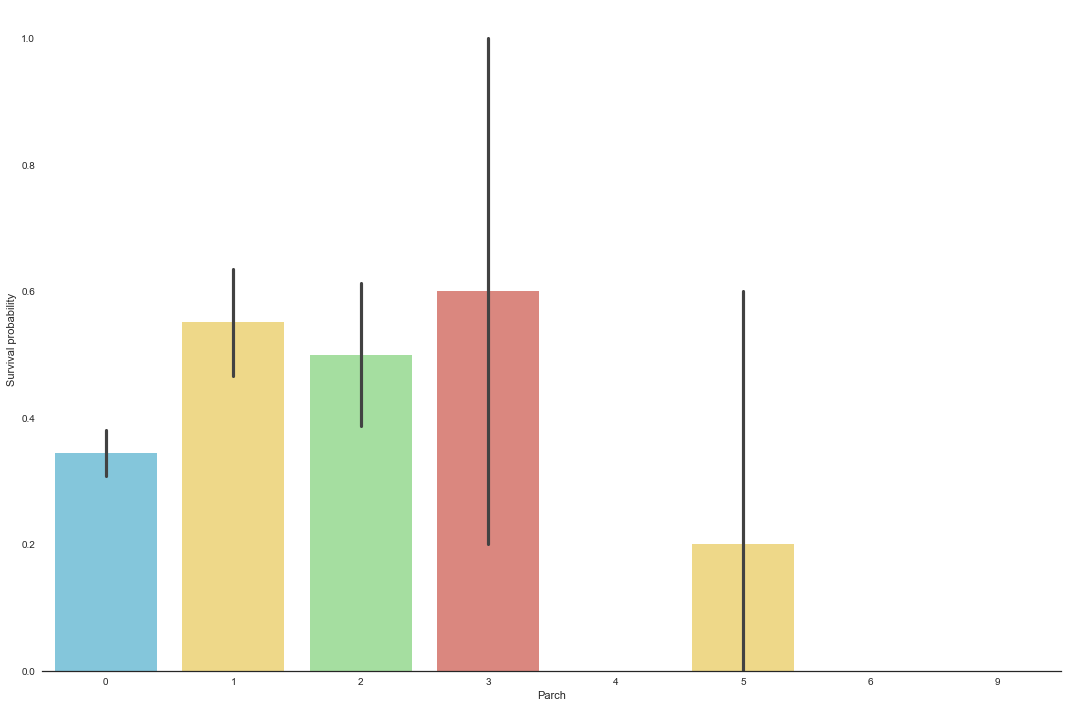

In [16]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x = "Parch", y = "Survived", data = full, kind = "bar", palette = mycols, size = 10, aspect = 1.5)
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 在这里我们可以看到，一般来说，**降低了乘客的父母和孩子的数量，乘客生存的可能性就越好**。
- 这可能有几个原因，例如在悲剧期间寻找其他家庭成员。
- 需要注意的一个值是Parch = 3，这显示了此功能存活的最高可能性。但是，它也有很高的标准偏差，这意味着该类别中的乘客的生存率与3名父母和船上孩子的平均存活率差别很大。
- 最后，虽然这是一个数字特征，但由于我们正在处理有限数量的离散值，我们将从现在开始将其视为**分类变量**。
- 此功能还可显示与乘客同行的家庭大小，因此我们稍后将使用它来构建新功能**“家庭规模”**。

### 3.2.4 - Pclass

- 与Parch类似，Pclass是一个数字特征，但它由有限个离散值组成 - 1，2和3.因此，分布图不适合于此。
- 我们将使用一个因子图来显示Pclass如何影响存活率。

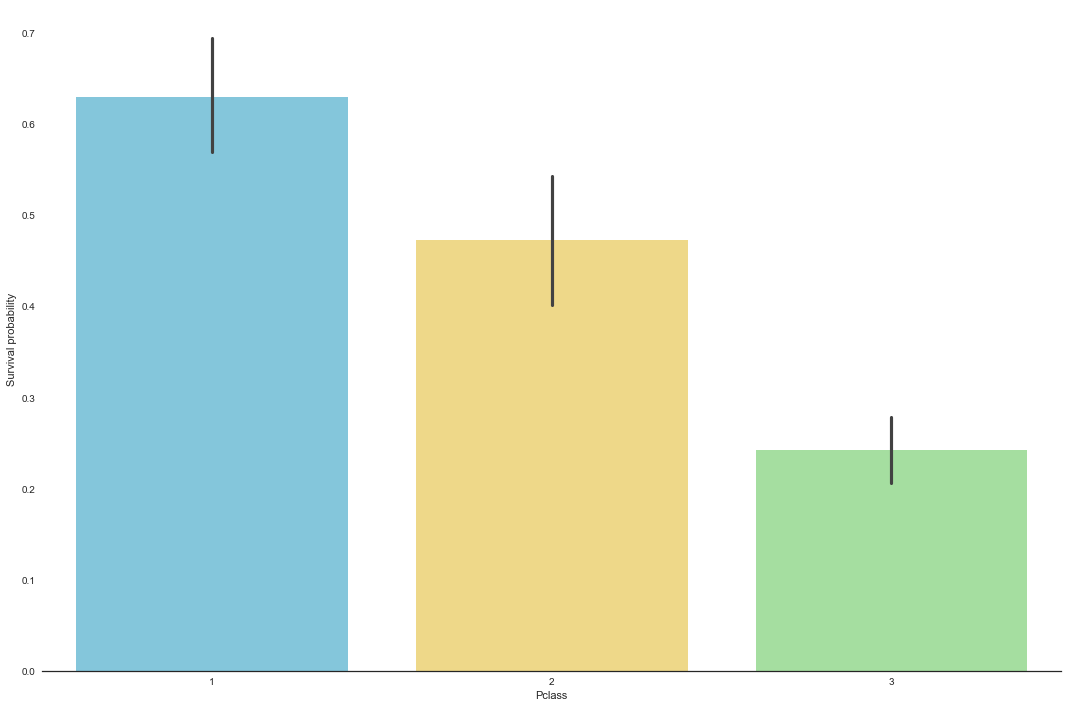

In [17]:
# Explore Pclass feature vs Survived
g  = sns.factorplot(x = "Pclass", y = "Survived", data = full, kind = "bar", palette = mycols, size = 10, aspect = 1.5)
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 我们可以在这里看到，当Pclass等级下降时，生存的机会减少。
- 第一类人有最好的生存机会 - 或许由于更高的社会经济地位而被优先考虑，或者他们位于有利位置（靠近出口的客舱）以逃生。
- 三级生存的可能性最大。

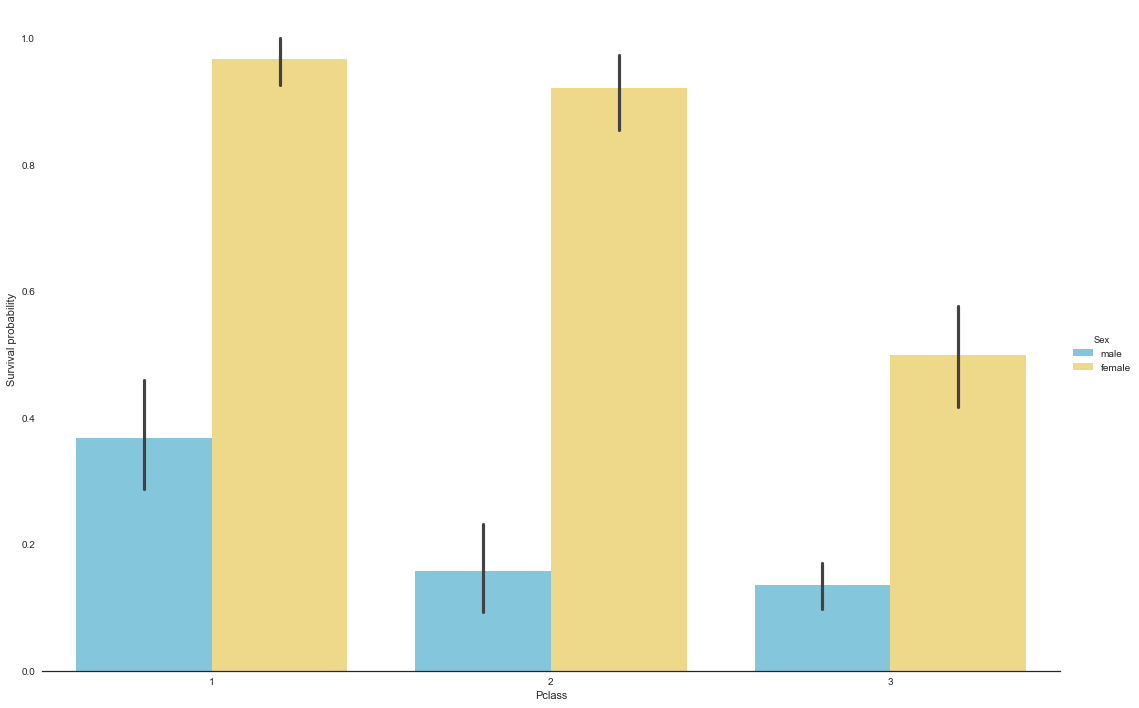

In [18]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=full,
                    kind="bar", palette=mycols, size = 10, aspect = 1.5)
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 上面讨论的生存机会在各种性别中也存在。
- 在低一级的Pclass中，男女的生存机会都降低。
- 然而，**女性显然比男性有更好的生存机会**。
- 与Parch类似，尽管Pclass是数值型的，但它将更好地被视为**分类特征**。

### 3.2.5 - SibSp

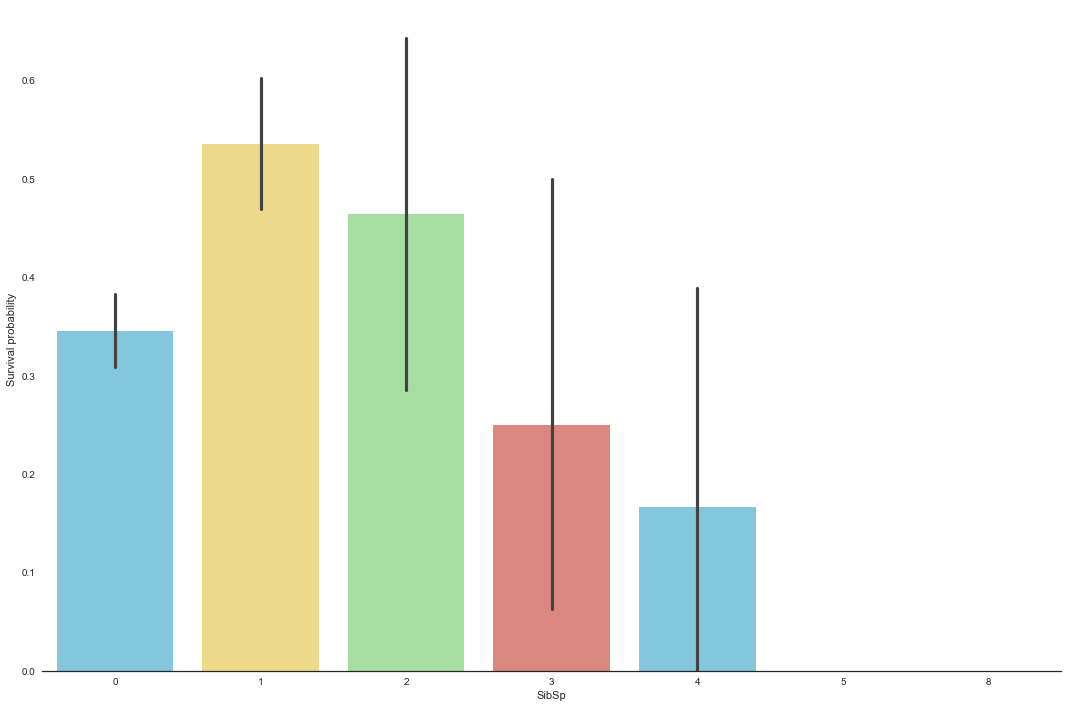

In [19]:
# Explore SibSp vs Survived
g = sns.factorplot(x="SibSp", y="Survived", data=full,
                    kind="bar", palette=mycols, size = 10, aspect = 1.5)
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 看起来乘客**有许多兄弟姐妹或配偶，生存的可能性较低**。也许这与“Parch”具有较高价值的乘客生存几率较低的理由紧密相关。
- 此功能与“Parch”一起可用于创建新变量，即**“Family Size”**。

### 3.3  - 离散值

现在我将分析数据集中的分类特征。这一探索性分析将帮助我构建一个关于下一阶段要创建哪些特征的概念，以及是否有预测生存的重要特征。

### 3.3.1 - Cabin

如前所述，当替换此列的缺失值时，这是一个有趣的功能，因为它可以充当许多事物的表征，例如：

- 票价
- 社会经济地位
- 在船上的位置，也许有些人可能位于有利的位置逃生

为了解决缺失的值，我们分配值'X'来表示这个乘客没有客舱。

我们来看看乘客是如何分布在客舱里的，以及客舱号是如何影响生存率的。

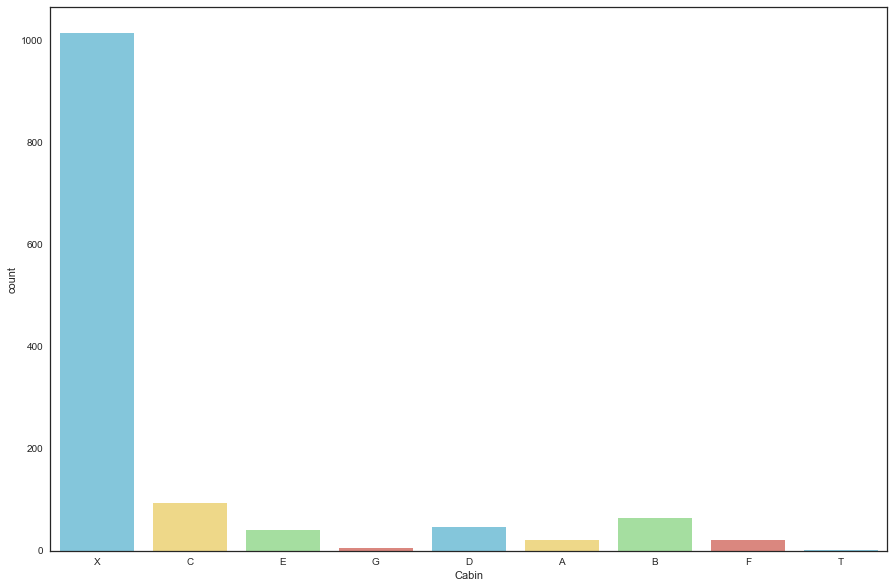

In [20]:
plt.subplots(figsize=(15, 10))
g = sns.countplot(x = "Cabin", data = full, palette = mycols)

- 我们可以从这个数字图上看出，**大多数乘客没有客舱**。 在此之后与大多数乘客相关的信是“B”和“C”。
- 我们可能会在“X”号舱内看到很多乘客，因为**大多数乘客都是第3级Pclass**。 因此，客舱可能已被分配到更高排名或更高的付费乘客，而较低票价的乘客可能已经在甲板上。

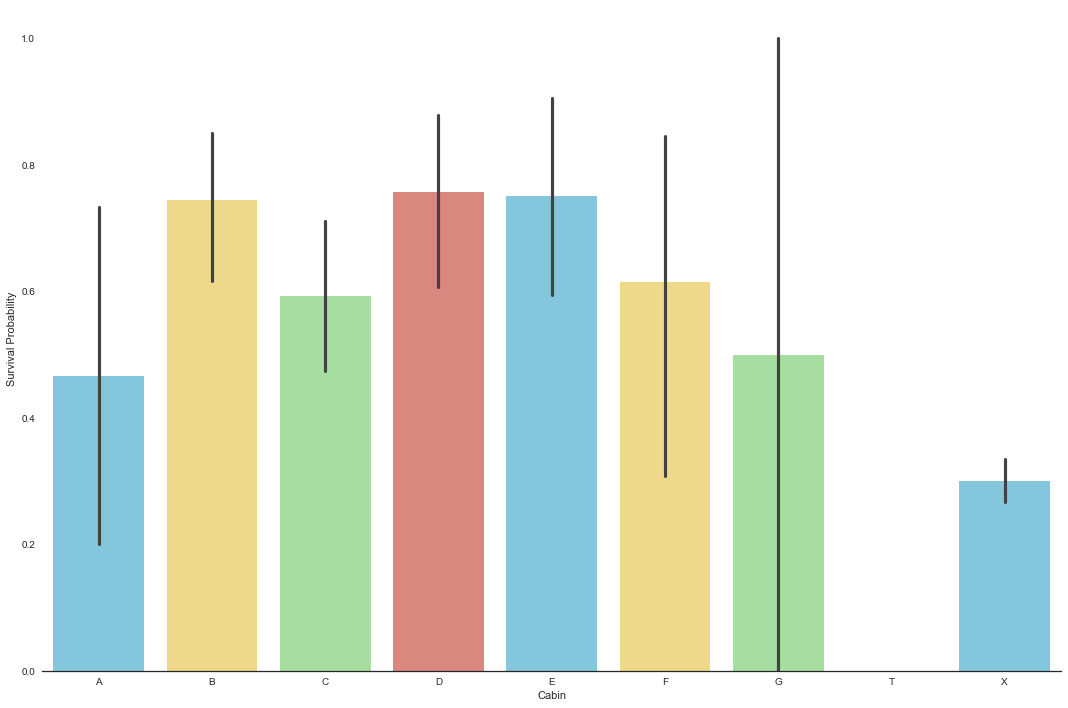

In [21]:
g = sns.factorplot(y = "Survived", x ="Cabin", data = full, kind = "bar", size = 10, aspect = 1.5,
                   order=['A','B','C','D','E','F','G','T','X'], palette = mycols)
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

- 有趣的是，我们可以在这里看到，**有客舱的乘客比没有的乘客拥有更好的生存机会**。 唯一的例外是客舱“T”，从前面的图表可以看出，乘客人数非常少。
- “X”的标准偏差没问题，而小木屋的标准偏差有所不同。 有些是可以接受的，但有些是非常高的。
- 这告诉我，虽然他们有更好的生存机会，但是**客舱之间的结果差异很大**。
- 这给我一个想法，**从这些类别创建虚拟变量，可能是一个不错的选择**。

### 3.3.2 - Embarked

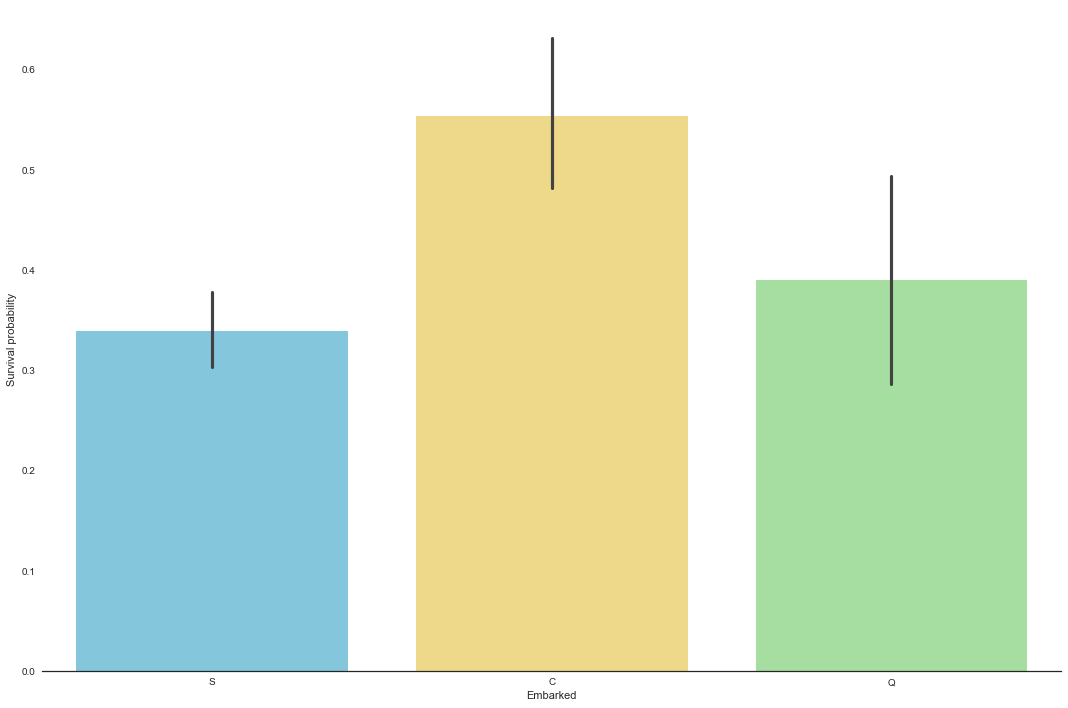

In [22]:
# Explore Embarked vs Survived
g = sns.factorplot(x="Embarked", y="Survived", data=full,
                    kind="bar", palette=mycols, size = 10, aspect = 1.5)
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 在这里我们可以看到**最高的生存率来自Cherbourg**，Queenstown和Southampton的乘客。
- 我们知道从Southampton出发的乘客数量最多，但**也许从这些港口出发的“类型”对他们的生存有影响**。

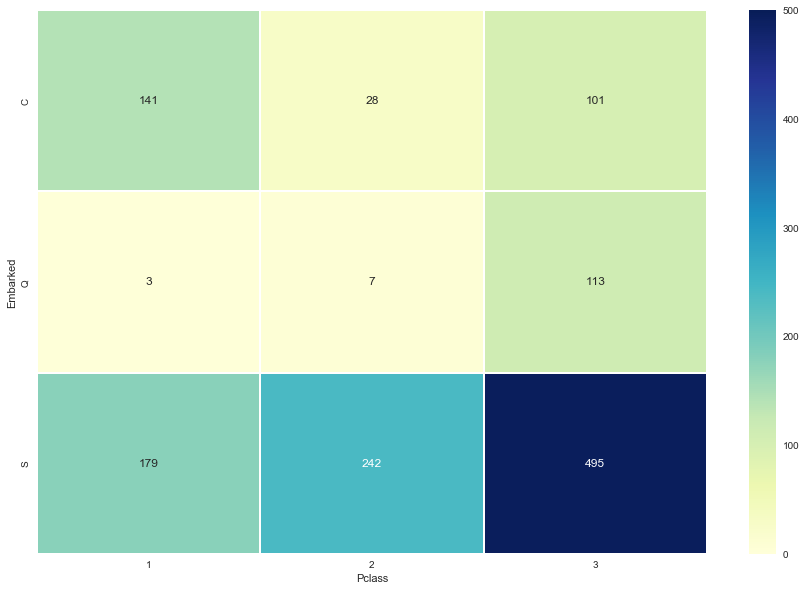

In [23]:
htmp = pd.crosstab(full['Embarked'], full['Pclass'])

plt.subplots(figsize=(15, 10))
g = sns.heatmap(htmp, cmap="YlGnBu", vmin = 0, vmax = 500, linewidths = 1, annot = True, fmt = "d");

- 这证实**Southampton拥有最多的三等乘客，但是也拥有最多的头等乘客**。
- 然而，Cherbourg也有大量的头等舱乘客。
- 也许头等舱乘客在悲剧期间被优先考虑，或者他们处于撤离的有利位置。
- 有趣的是，回顾最初的研究......登船的第一个港口是Southampton，然后是Cherbourg，然后是Queenstown。Southampton的头等舱乘客人数最多，但生存率最低。这可能是因为他们被装在船上的较低甲板和客舱中，为了留出空间并允许更轻松地将乘客装载到Cherbourg和Queenstown的上层甲板上？只是一个值得调查的想法。

### 3.3.3 - 性别

- 我们都记得那句话是怎么回事...... **“女人和孩子优先！”**
因此，如果没有对任何事物进行可视化，就很容易理解我们可能会看到的内容
- 我将在下面证实这些假设，然后探讨男性和女性的生存如何影响其他特征。

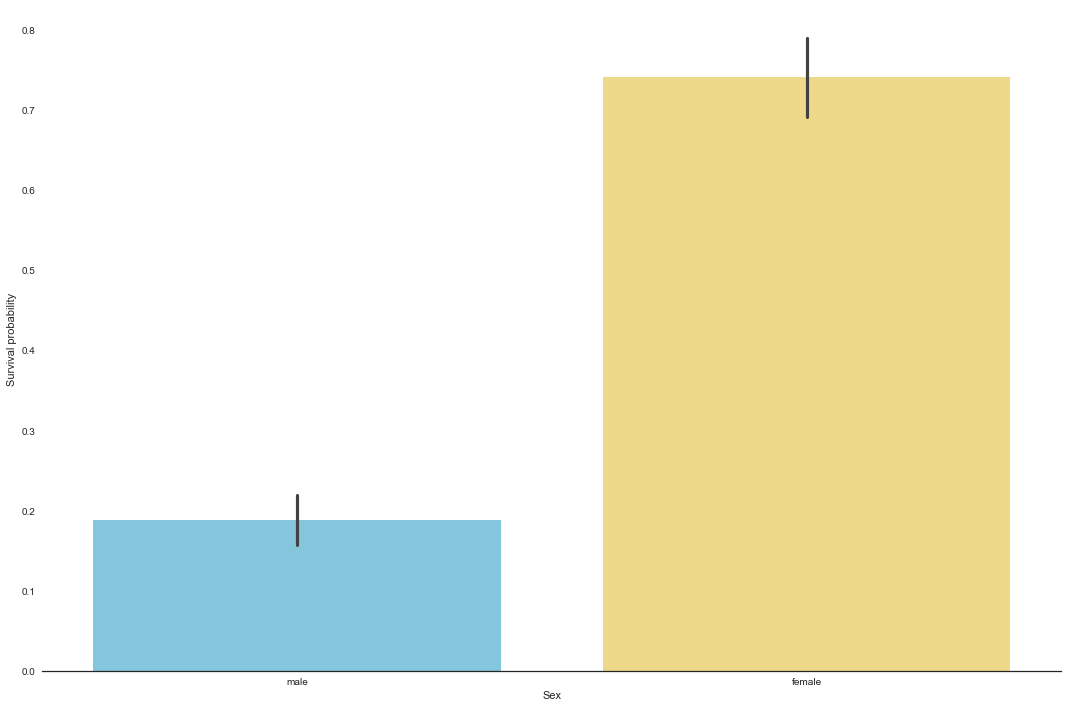

In [24]:
# Explore Sex vs Survived
g = sns.factorplot(x="Sex", y="Survived", data=full,
                    kind="bar", palette=mycols, size = 10, aspect = 1.5)
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 正如所料，**女性的存活率明显高于男性。**
- **注意**：为了使算法能够处理该列。 在特征工程中，我将用1和0代替男/女编码这个变量。
- 现在探索其他特征中男性和女性的生存率。

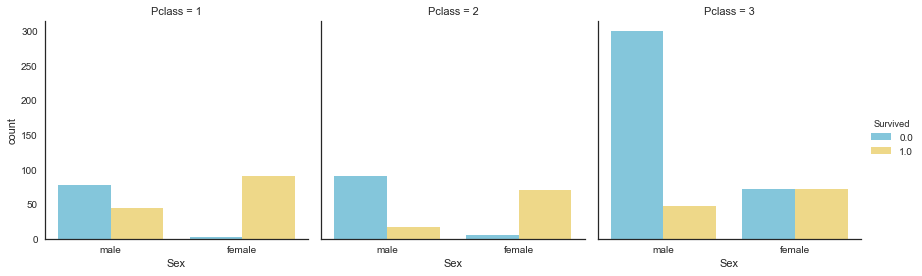

In [25]:
sns.factorplot(x="Sex", col = "Pclass", hue = "Survived", data=full, kind="count");

- **女性在各层的生存率都较好**。 但对于男性来说，**三等乘客没有很好的生存机会**。
- 更多的男性幸存者实际上来自二等，而不是一等。
- 女性死亡人数最多来自三等

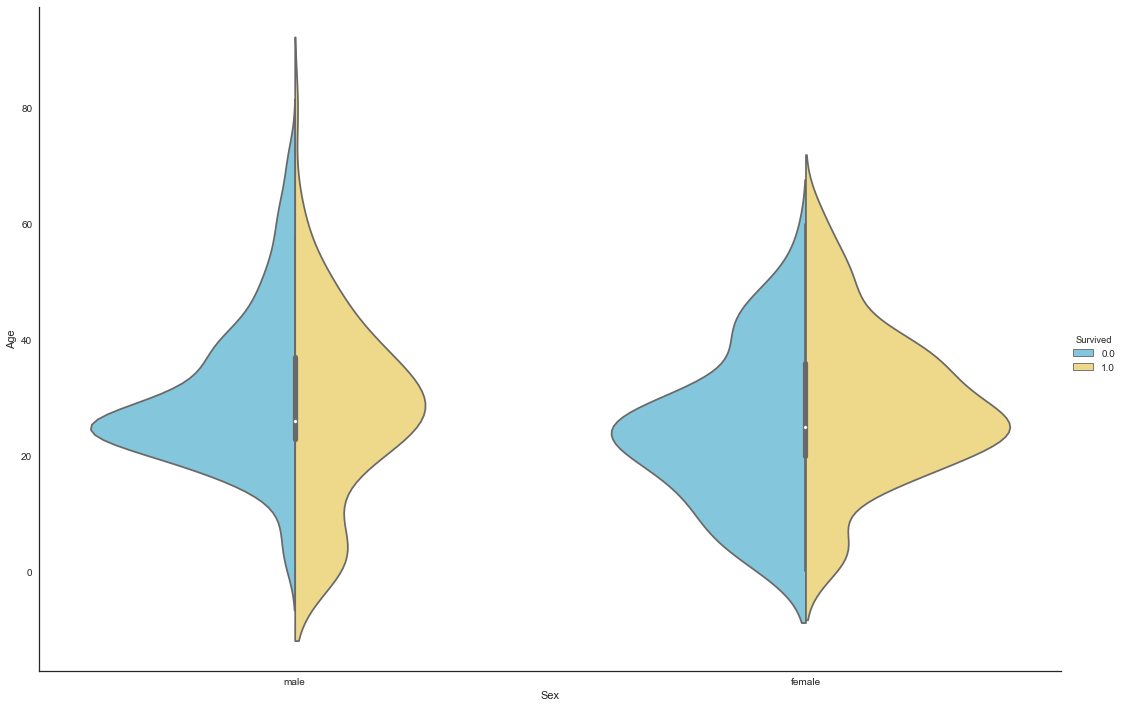

In [26]:
sns.factorplot(x="Sex", y = "Age", hue = "Survived", data=full, kind="violin",
               split = True, size = 10, aspect = 1.5);

- 现在关注“年龄”。 我们可以在这里看到，对于**男性非幸存者，正态分布略有正偏态**。 然而，对于幸存的男性来说，有一大群年龄很小的幸存者** - 可能表明年幼的孩子或婴儿**。 然后，我们在** 30岁**附近又有一个高峰。
- 对于女性来说，**年轻女性死亡比例大于10岁及以下**。
- 然而，在查看幸存者时，女性幸存者的数量最多是** 25岁左右**，并且还有大量40岁左右的女性幸存下来。
- **年龄显然对性别**的生存影响很大。

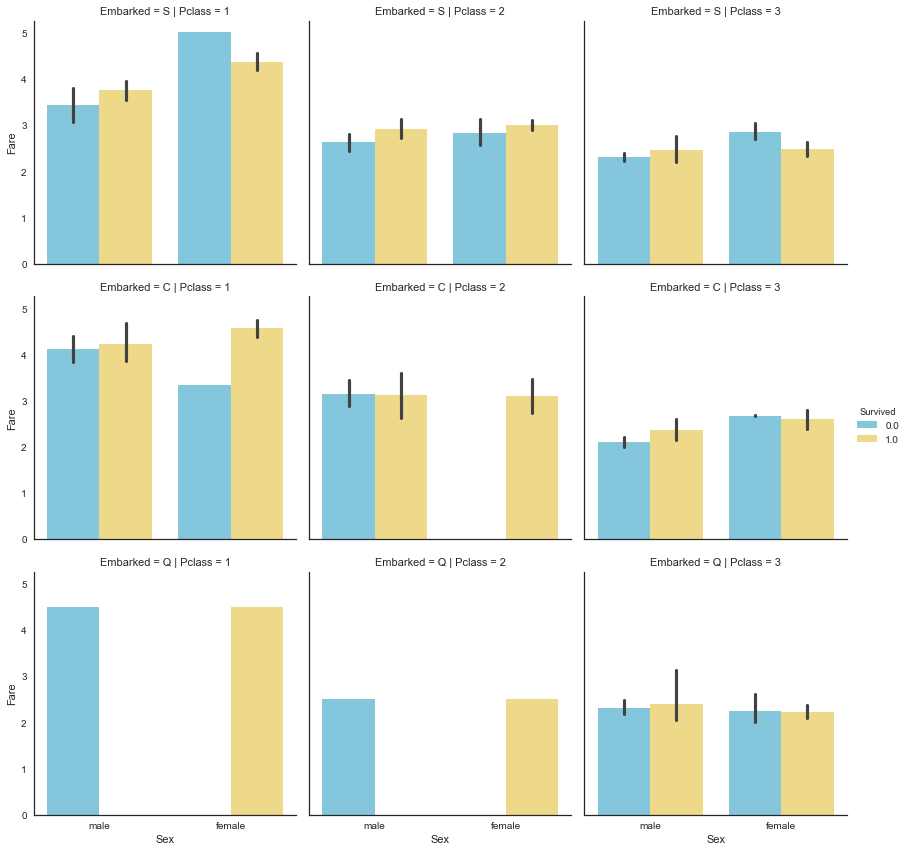

In [27]:
sns.factorplot(x="Sex", y="Fare", hue="Survived", col = "Pclass", row="Embarked", data=full, kind="bar");

- 此外，还不清楚幸存者是否比非幸存者支付更多或更少，因为这种情况并不一致。
- 有趣的是，从皇后镇出发乘坐第一和第二班的乘客。 没有男性幸存，没有女性死亡。

这完成了** 特征分析 **，并为我决定如何进行** 特征工程（FE） **提供了良好的基础。

# 4
## 特征工程

- 在本节中，我将用多种方法创建各种新变量。
- 对于分类变量，可以**编码每个类别以获得数字表示**。
     - 例如对于Embarked列，我们可以编码“S”，“C”和“Q”分别表示为0,1和2。
- 但是，我决定为列中的每个类别创建**虚拟变量**。这将用每个类别的独立列代替原始列，用**标志**代表该乘客是否与该类别相关联。
- 对于数值变量，我们已经看到**有一些值表明更好的生存机会**。所以我会将它们转换成**分类的类别**并从它们中创建**虚拟变量**。
- 我还将通过结合现有的功能创建一些全新的功能。


### 4.1 - Age

- 正如分析这一特征所讨论的那样，生存率与年龄差异很大。
- 因此，我们将**将此特征分类处理**。

In [28]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,X,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,X,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,X,S,2.085672,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [29]:
# Creating a new feature by cutting the Age column into 5 bins
full['Age Band'] = pd.cut(full['Age'], 5)

# Now lets see the age bands that pandas has created and how survival is affected by each
full[['Age Band', 'Survived']].groupby(['Age Band'], as_index=False).mean().sort_values(by='Age Band', 
                                                                                          ascending=True)

,Age Band,Survived
0,"(0.0902, 16.136]",0.500000
1,"(16.136, 32.102]",0.341719
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


- 我现在想用有意义的值替换这些bin，并从中创建虚拟变量。

In [30]:
# Locate and replace values
full.loc[full['Age'] <= 16.136, 'Age'] = 1
full.loc[(full['Age'] > 16.136) & (full['Age'] <= 32.102), 'Age'] = 2
full.loc[(full['Age'] > 32.102) & (full['Age'] <= 48.068), 'Age']   = 3
full.loc[(full['Age'] > 48.068) & (full['Age'] <= 64.034), 'Age']   = 4
full.loc[ full['Age'] > 63.034, 'Age'] = 5
full['Fare'] = full['Fare'].astype(int)

# Replace with categorical values
full['Age'] = full['Age'].replace(1, '0-16')
full['Age'] = full['Age'].replace(2, '16-32')
full['Age'] = full['Age'].replace(3, '32-48')
full['Age'] = full['Age'].replace(4, '48-64')
full['Age'] = full['Age'].replace(5, '64+')


# Creating dummy columns for each new category, with a 1/0
full = pd.get_dummies(full, columns = ["Age"], prefix="Age")

# Deleting the Age and Age Band column as they are no longer needed
drop = ['Age Band']
full.drop(drop, axis = 1, inplace = True)

full.head(n=3)

,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_0-16,Age_16-32,Age_32-48,Age_48-64,Age_64+
0,X,S,1,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,1,0,0,0
1,C,C,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,0,1,0,0
2,X,S,2,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,1,0,0,0


### 4.2 - Cabin

- 我们之前已经完成了一部分工作，现在只需要创建虚拟变量就好。

In [31]:
full = pd.get_dummies(full, columns = ["Cabin"], prefix="Cabin")
full.head(3)

,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,Age_64+,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,S,1,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,...,0,0,0,0,0,0,0,0,0,1
1,C,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,...,0,0,0,1,0,0,0,0,0,0
2,S,2,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,...,0,0,0,0,0,0,0,0,0,1


### 4.3 - Embarked

- 这个特征分为3类，我们只需要创建3个虚拟变量。

In [32]:
full = pd.get_dummies(full, columns = ["Embarked"], prefix="Embarked")
full.head(3)

,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_0-16,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S
0,1,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,...,0,0,0,0,0,0,1,0,0,1
1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,...,1,0,0,0,0,0,0,1,0,0
2,2,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,...,0,0,0,0,0,0,1,0,0,1


### 4.4 - Fare

- 就像年龄，我们需要弄清楚我们如何**将这个特征分类**。 我们原来有的一些极端值造成了一个正偏态分布。 现在我们使用**对数转换**来清除它。
- 通常情况下，对于偏斜的分布，我会使用**“分位数剪切”**来分割一个特征。
     - 原因是**“cut”根据数值本身而不是这些数值的频率创建等间隔的区间**。
     - 因为年龄是正态分布的，所以你会在内区间看到更高的频率，而在外部看到更少的频率。 这实质上将反映正态分布的钟形曲线。
         - 但是使用“qcut”时，这个区间会被选择以便在每个区间中具有相同数量的记录。
- 但是，新转换的Fare列具有类似于Age的偏度，所以我将使用**“cut”**创建箱。

In [33]:
full['Fare Band'] = pd.cut(full['Fare'], 4)
full[['Fare Band', 'Survived']].groupby(['Fare Band'], as_index=False).mean().sort_values(by='Fare Band', 
                                                                                          ascending=True)

,Fare Band,Survived
0,"(-0.006, 1.5]",0.130952
1,"(1.5, 3.0]",0.349850
2,"(3.0, 4.5]",0.696429
3,"(4.5, 6.0]",0.689655


- 现在我将使用“.loc”来定位每个区间，并将其替换为1-4中的编码数字。
- 在此之后，我将用分类值替换它以创建虚拟变量。

In [34]:
# Locate and replace values
full.loc[ full['Fare'] <= 1.56, 'Fare'] = 1
full.loc[(full['Fare'] > 1.56) & (full['Fare'] <= 3.119), 'Fare'] = 2
full.loc[(full['Fare'] > 3.119) & (full['Fare'] <= 4.679), 'Fare']   = 3
full.loc[ full['Fare'] > 4.679, 'Fare'] = 4
full['Fare'] = full['Fare'].astype(int)

# Replace with categorical values
full['Fare'] = full['Fare'].replace(1, 'Very low')
full['Fare'] = full['Fare'].replace(2, 'Low')
full['Fare'] = full['Fare'].replace(3, 'Medium')
full['Fare'] = full['Fare'].replace(4, 'High')

# Create dummy variables
full = pd.get_dummies(full, columns = ["Fare"], prefix="Fare")

# Drop the un-needed Fare Band column
drop = ['Fare Band']
full.drop(drop, axis = 1, inplace = True)

full.head(n=3)

,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_0-16,Age_16-32,...,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Fare_High,Fare_Low,Fare_Medium,Fare_Very low
0,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,1,...,0,0,1,0,0,1,0,0,0,1
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,0,...,0,0,0,1,0,0,0,0,1,0
2,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,1,...,0,0,1,0,0,1,0,1,0,0


### 4.5 - Title

- 如前所述，“Title栏本身并没有太多的意义。
- 但是，如果我们从名称中提取**标题**并对其进行分类，可能会有趣的事。

In [35]:
# Extracting Title from the Name feature
full['Title'] = full['Name'].str.extract(' ([A-Za-z]+)\.', expand=True)

# Displaying number of males and females for each Title
pd.crosstab(full['Sex'], full['Title'])

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


- 目标是从这个“标题”列创建类别。 从交叉表中可以看出，我们有一些Title几乎没有乘客。
- 其中一些可以与其他Title**合并**，例如Mlle和Miss与Miss。
- 有些标题非常稀少，所以我可以将它们归类为**稀少**分类。

In [36]:
# Merge titles with similar titles
full['Title'] = full['Title'].replace('Mlle', 'Miss')
full['Title'] = full['Title'].replace('Ms', 'Miss')
full['Title'] = full['Title'].replace('Mme', 'Mrs')

# Now lets see the crosstab again
pd.crosstab(full['Sex'], full['Title'])

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mr,Mrs,Rev,Sir
Sex,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,264,0,198,0,0
male,1,4,0,1,0,7,1,0,2,61,0,757,0,8,1


In [37]:
# Now I will replace the rare titles with the value "Rare"
full['Title'] = full['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                       'Don', 'Dr', 'Major', 'Rev',
                                       'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
# Let's see how these new Title categories vary with mean survival rate
full[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


- 我们现在有5个有意义的类别。 我们可以看到，"Mrs"生存的可能性最高，"Mr" 最低。
- 最后要做的是用这些新的“标题”类别创建一些虚拟变量。

In [38]:
# Create dummy variables for Title
full = pd.get_dummies(full, columns = ["Title"], prefix="Title")

# Drop unnecessary name column
drop = ['Name']
full.drop(drop, axis = 1, inplace = True)

full.head(3)

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_0-16,Age_16-32,Age_32-48,...,Embarked_S,Fare_High,Fare_Low,Fare_Medium,Fare_Very low,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,1,3,male,1,0.0,A/5 21171,0,1,0,...,1,0,0,0,1,0,0,1,0,0
1,0,2,1,female,1,1.0,PC 17599,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,3,3,female,0,1.0,STON/O2. 3101282,0,1,0,...,1,0,1,0,0,0,1,0,0,0


### 4.6 -FamilySize

- 我将构建的下一个特征是使用“Parch”和“SibSp”来显示船上家庭的相关大小。
- 这是** Parch + SibSp + 1 **的简单求和
- 我们加1来创建包含乘客的家庭大小的特征。

- 同样根据我们之前对SibSp和Parch的分析，我们发现**生存的几率在每个离散值**之间差异很大。
- 一般来说，Parch和SibSp的数量越低，生存的机会就越大。
- 因此，我们将使用此Family Size特性来构造一些**分级特征**。

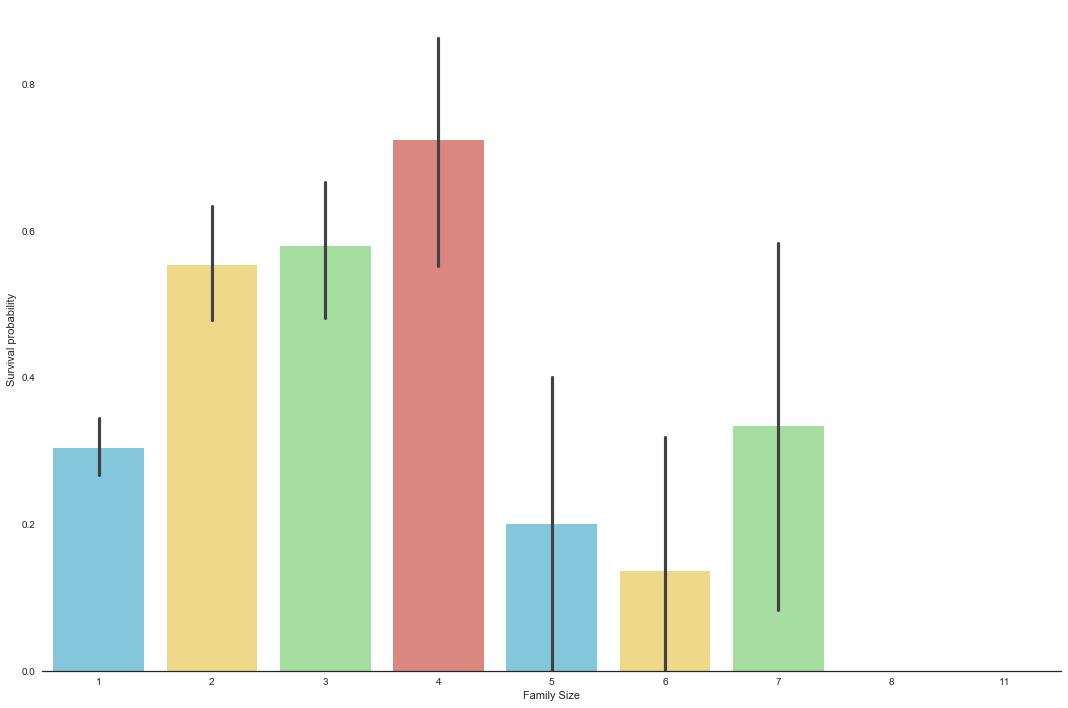

In [39]:
# First creating the Family Size feature
full['Family Size'] = full['SibSp'] + full['Parch'] + 1

# Explore Family Size vs Survived
g = sns.factorplot(x="Family Size", y="Survived", data=full,
                    kind="bar", palette=mycols, size = 10, aspect = 1.5)
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 正如我们对Parch和SibSp的分析所预期的，** Family Size遵循类似的模式**。
- 有趣的是，在值为4之后，存活率降低，但是随后达到7。然而，这些较大的值具有高标准偏差。

In [40]:
# Now to bin the Family Size feature into bins
full['Lone Traveller'] = full['Family Size'].map(lambda s: 1 if s == 1 else 0)
full['Party of 2'] = full['Family Size'].map(lambda s: 1 if s == 2  else 0)
full['Medium Family'] = full['Family Size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
full['Large Family'] = full['Family Size'].map(lambda s: 1 if s >= 5 else 0)

# Delete the no longer needed Family Size
drop = ['Family Size']
full.drop(drop, axis = 1, inplace = True)

full.head(n=3)

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_0-16,Age_16-32,Age_32-48,...,Fare_Very low,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Lone Traveller,Party of 2,Medium Family,Large Family
0,0,1,3,male,1,0.0,A/5 21171,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,0,2,1,female,1,1.0,PC 17599,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,0,3,3,female,0,1.0,STON/O2. 3101282,0,1,0,...,0,0,1,0,0,0,1,0,0,0


### 4.7 - Sex

- 我们对性别做的是将分类字符串值转换为1/0。

In [41]:
# Convert Sex into categorical value - 0 for male and 1 for female
full["Sex"] = full["Sex"].map({"male": 0, "female":1})
full.head()

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_0-16,Age_16-32,Age_32-48,...,Fare_Very low,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Lone Traveller,Party of 2,Medium Family,Large Family
0,0,1,3,0,1,0.0,A/5 21171,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,0,2,1,1,1,1.0,PC 17599,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,0,3,3,1,0,1.0,STON/O2. 3101282,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,0,4,1,1,1,1.0,113803,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4,0,5,3,0,0,0.0,373450,0,0,1,...,0,0,0,1,0,0,1,0,0,0


### 4.8 - Ticket

- 票是一个有趣的属性，因为我们有许多独特的类别，但票号内是一些编码信息。
- 一些门票在开头有字母，表示与港口有一些关联。
     - 有些纯粹是数字。
- 但是，我相信此功能中可能会提供一些有用的信息。 我要做的是**创建一个标志来表明票证是否包含字母**的前缀特征。
- 我可以为每个单独的前缀或只有字母的前缀创建虚拟变量。 但是我认为在这种情况下将包括字母在内的所有前缀都包含在一个标记中会更好，因为前缀很多。

In [42]:
# First, I want to create a new column that extracts the prefix from the ticket.
# In the case where there is no prefix, but a number... It will return the whole number.

# I will do this by first of all creating a list of all the values in the column
tickets = list(full['Ticket'])

# Using a for loop I will create a list including the prefixes of all the values in the list
prefix = []
for t in tickets:
    split = t.split(" ", 1) # This will split each value into a list of 2 values, surrounding the " ". For example, the ticker "A/5 21171" will be split into [A/5, 21171]
    prefix.append(split)
    
# Now I want to take the first value within these lists for each value. I will put these into another list using a for loop.
tickets = []
for t in prefix:
    ticket = t[0]
    tickets.append(ticket)
    
full['Ticket_Prefix'] = pd.Series(tickets)
full.head(3)

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_0-16,Age_16-32,Age_32-48,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Lone Traveller,Party of 2,Medium Family,Large Family,Ticket_Prefix
0,0,1,3,0,1,0.0,A/5 21171,0,1,0,...,0,0,1,0,0,0,1,0,0,A/5
1,0,2,1,1,1,1.0,PC 17599,0,0,1,...,0,0,0,1,0,0,1,0,0,PC
2,0,3,3,1,0,1.0,STON/O2. 3101282,0,1,0,...,0,1,0,0,0,1,0,0,0,STON/O2.


- 现在我们有前缀，或者在没有前缀的票证的情况下有数字。
- 最后要做的事情是创建一个**标志来表明有票有前缀或不带前缀**的乘客特征。
- 我这样做的方式是创建一个函数，为所有以0-9开头的条目分配一个0，并将1分配给其他所有条目，即带有前缀的值。

In [43]:
# Create the function
def TicketPrefix(row):
    for t in row['Ticket_Prefix']:
        if t[0] == '0':
            val = 0
        elif t[0] == '1':
            val = 0
        elif t[0] == '2':
            val = 0
        elif t[0] == '3':
            val = 0
        elif t[0] == '4':
            val = 0
        elif t[0] == '5':
            val = 0
        elif t[0] == '6':
            val = 0
        elif t[0] == '7':
            val = 0
        elif t[0] == '8':
            val = 0
        elif t[0] == '9':
            val = 0
        else:
            val = 1
        return val
    
# Create a new column that appolies the above function to create its values        
full['Ticket Has Prefix'] = full.apply(TicketPrefix, axis = 1)

# Clean up variables not needed anymore
drop = ['Ticket', 'Ticket_Prefix', 'PassengerId'] # We delete passenger ID here as it is no use for the modeling
full.drop(drop, axis = 1, inplace = True)

full.head(3)

,Parch,Pclass,Sex,SibSp,Survived,Age_0-16,Age_16-32,Age_32-48,Age_48-64,Age_64+,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Lone Traveller,Party of 2,Medium Family,Large Family,Ticket Has Prefix
0,0,3,0,1,0.0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,0,1,1,1,1.0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
2,0,3,1,0,1.0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1


- 我们现在完成了特征工程。 我尝试了许多不同的方法，包括**创建多项式和交互变量**。
- 如果您希望创建交互变量，则必须以不同方式对初始要素进行编码，因为**您不希望乘以其中包含0的两个变量**。
     - 我们举一个例子 - 我们有两列有3个类别，用0,1和2表示。如果你从这两个特征创建一个交互变量，那么5个交互都将= 0，并且它将不可能区分创建它的类别的组合。
- 我之所以决定创建尽可能多的特征，是因为我打算**将这些特征专门分配到每个算法**，因为它们会对每个功能赋予不同的重要性。

### 4.8 - 所有特征的相关性

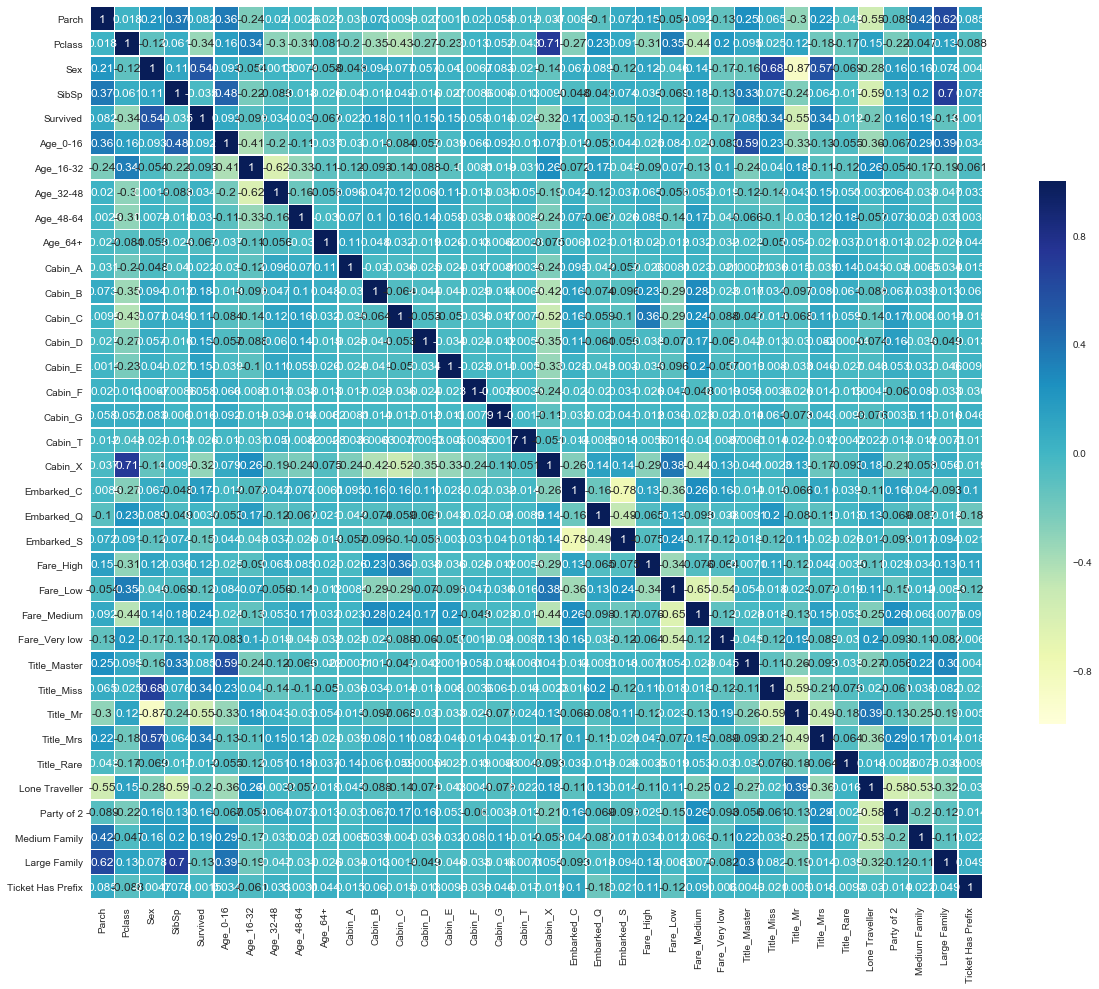

In [44]:
corr = full.corr()
plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="YlGnBu", vmin = -1.0, vmax = 1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True);

- 我们可以看到，我们有很多特征，并且在存活和特征之间有一些很好的相关性。
- 一个要注意的事情是**多重共线性**。
     - ***我们模型中的预测特征可以从其他特征线性预测出来具有相当程度的准确性***。
         - 即我们在预测特征之间有很高的相关性，这就是我们想要避免的，因为这表明一个人可以准确地预测另一个，或者一个人的价值可能被编码在另一个之内，从本质上告诉我们同样的事情。
         - 多重共线性可能导致问题不是因为它会降低模型的预测能力，但它会**影响关于单个特征**的计算。
             - 意思是说，如果我们有一个带共线预测因子的模型，它可以表明整个预测因子集可以预测我们试图找到的结果。但它可能无法提供有关任何单个特征的有效结果。 **当我们使用依赖于为特征分配不同权重的算法时，这可能成为一个问题**。
- 看看关联热图，我们没有紧迫的问题。然而，我们确实有一些例子，有很高的相关性。为了克服这个问题，我们将在下一节**中减少每个模型的特征**。

# 5.
## Modeling
### 5.1 - Preparation of data

- 所有特征都准备好了，可以用测试数据和训练数据开始训练模型。

In [45]:
# First I will take a copy of the full dataset, in case we need to change or use the full dataset for something else.
copy = full.copy()

# Remember that the training dataset had only 891 rows, and the test had 418. 
# At the start we simply concatenated the two datasets together to form our "full" dataset
# Hence, we can simply split the two datasets apart again to extract the training and test data.
train_setup = copy[:891]
test_setup = copy[891:]

# I'll take another copy just to be safe
train = train_setup.copy()
test = test_setup.copy()

# And print the shape of these dataframes to confirm it has done what I intended
print('train: ', train.shape, '\ntest: ', test.shape)

train:  (891, 36) 
test:  (418, 36)


- 您会注意到，从上面的表格中，“Survived”显示为浮点数。
- 因此，为了稍后输出文件被Kaggle接受，**我将把它转换为一个整数**。
- 请注意，我们的测试数据集应具有35个特征，因为“生存”功能最初缺失。
- 你会发现在这个新的测试数据集中“Survived”的所有值都将用NaN填充。
- 因此，我们可以不删除这个列。

In [46]:
# Convert the "Survived" column in the training data to an integere
train['Survived'] = train['Survived'].astype(int)

# Drop the "Survived" column from the test data
drop = ['Survived']
test.drop(drop, axis=1, inplace=True)

print('train: ', train.shape, '\ntest: ', test.shape)

train:  (891, 36) 
test:  (418, 35)


- 现在我将**将训练数据集的预测特征与“我们想要预测**”的“Survived”列中分开来。
- 我们这样做的原因是因为稍后运行的算法需要两个输入，** X **和** Y **，表示模型的特征以及期望的预测结果。

In [47]:
# Take another copy for the training features, because why not
train_x = train.copy()

# Now delete the "Survived" column from the training features
del train_x['Survived']

# And create a new column called train_y representing what we are trying to predict for the training dat
train_y = train['Survived']

# Confirm this all worked
print('train_x - features for training: ', train_x.shape, '\ntrain_y - target variable for training: ', train_y.shape,)

train_x - features for training:  (891, 35) 
train_y - target variable for training:  (891,)


- 我们可以看到，我们有35个用于训练891行的特征，这正是我们想要的特征。
- 我们的目标列只有1列，横跨891行，1/0。
- 接下来，我们将采用我们刚刚构建的训练数据集和目标列，并且将**创建样本**。
     - 我们这样做的原因是，我们可以有一个**估计，验证和测试数据集**。
     - 我们已经有了测试数据集，这是我们将应用最终模型并提交给Kaggle的预测数据集。
     - 但是，我们现在将**将训练数据集分成两个较小的集合。这样我们可以训练我们的模型，然后根据验证样本进行测试**。
         - 我们这样做是为了让我们确信**模型是健壮的！**
         - 我们不想生成一个能够以100％的准确度预测训练数据集的模型，但不能推广到新数据，因为它已经将训练数据过于密切地学习了（过拟合）。
         - 因此，为了**创建能够处理新数据的模型**，这些数据可能与训练数据有所不同 - 我们必须在模型释放之前对模型进行测试。
         - 我们正在寻找的是一种在预测估计数据集方面表现良好的模型，但也能够高精度地预测验证数据集的结果，而无需查看目标列进行验证。

In [48]:
# To do this, we will use the neat package train_test_split
# This allows you to split your dataset into smaller training and test samples, controlling how much goes into each.
# For this, we will assign 25% to the validation dataset
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(train_x, train_y, test_size=0.25, random_state=42)

# X_train = predictor features for estimation dataset
# X_test = predictor variables for validation dataset
# Y_train = target variable for the estimation dataset
# Y_test = target variable for the estimation dataset

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (668, 35) 
X_test:  (223, 35) 
Y_train:  (668,) 
Y_test:  (223,)


- 现在我们已经准备好用我们的算法进行建模了！耶！

## 5.2 - 模型比较

- 我们试图预测的是“生存”。我们已经看到这是一个**二进制特征**，这意味着它只能取值1/0。
- 这立即缩小了我们可以选择的算法的问题。我们必须选择的算法类别称为**“分类”**算法，这是一种能够预测1和0的算法的有监督学习类。
幸运的是，我们有很多分类算法可供选择。我决定采用scikit-learn软件包中的各种算法。

我选择的算法如下：

***基于树：***
- 决策树分类器

***集成学习：***
- 随机森林分类器
- Extra tree分类器
- AdaBoost分类器
- XGBoost
- 梯度增强分类器

***支持向量机：***
- 支持向量机分类器
- 线性支持向量机分类器

***邻居：***
- K-最近邻分类器

***神经网络：***
- 多层感知器分类器

***线性： ****
- Perceptron
- Logistic回归
- 随机梯度下降分类器

***朴素贝叶斯：***
- 高斯朴素贝叶斯

***表决：***
- 集成投票分类器

*我的解释并不是详尽无遗的。我创建了图形，以轻松易懂的方式介绍算法。这将为您了解他们如何以及他们如何工作奠定坚实的基础。有关更多详细信息，请参阅提供的参考资料。*

### 5.2.1 - 算法A-Z



### 5.2.2 - 对比

- 现在我用这个 **估计数据集**来运行以上模型, 并对结果进行交叉验证。 

- 为了保证模型的表现, 我会 **用验证集测试训练出的模型**。
- 在优化了算法后，我会运行“投票”分类器来进一步工作。

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

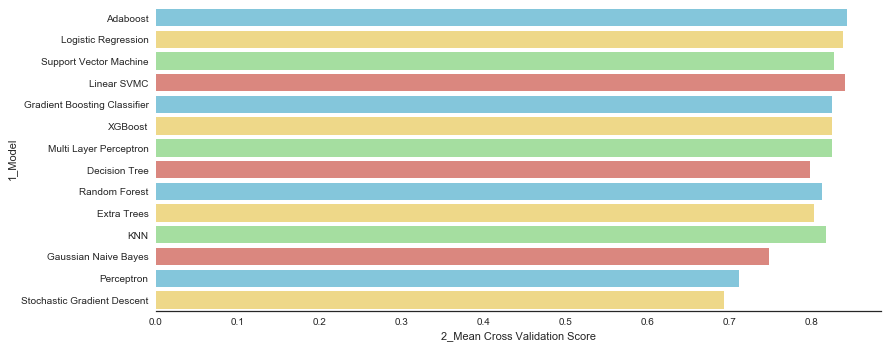

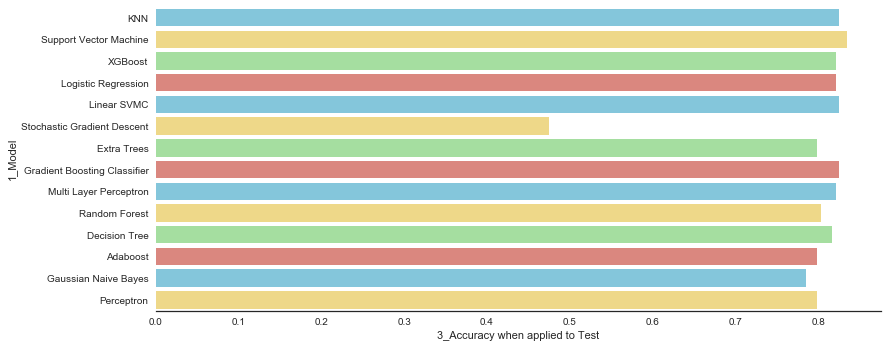

In [49]:
# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=3, test_size=0.2, random_state=50)

# Decision Tree
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, Y_train)
dt_scores = cross_val_score(dt, X_train, Y_train, cv = shuff)
dt_scores = dt_scores.mean()
dt_apply_acc = metrics.accuracy_score(Y_test, dt.predict(X_test))

# Random Forest
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, Y_train)
rf_scores = cross_val_score(rf, X_train, Y_train, cv = shuff)
rf_scores = rf_scores.mean()
rf_apply_acc = metrics.accuracy_score(Y_test, rf.predict(X_test))

# Extra Trees
etc = ExtraTreesClassifier(random_state=0)
etc.fit(X_train, Y_train)
etc_scores = cross_val_score(etc, X_train, Y_train, cv = shuff)
etc_scores = etc_scores.mean()
etc_apply_acc = metrics.accuracy_score(Y_test, etc.predict(X_test))

# Adaboost classifier
ada = AdaBoostClassifier(random_state=0)
ada.fit(X_train, Y_train)
ada_scores = cross_val_score(ada, X_train, Y_train, cv = shuff)
ada_scores = ada_scores.mean()
ada_apply_acc = metrics.accuracy_score(Y_test, ada.predict(X_test))

# xgboost
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, Y_train)
xgb_scores = cross_val_score(xgb, X_train, Y_train, cv = shuff)
xgb_scores = xgb_scores.mean()
xgb_apply_acc = metrics.accuracy_score(Y_test, xgb.predict(X_test))

#gradient boosting classifier
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, Y_train)
gbc_scores = cross_val_score(gbc, X_train, Y_train, cv = shuff)
gbc_scores = gbc_scores.mean()
gbc_apply_acc = metrics.accuracy_score(Y_test, gbc.predict(X_test))

# Support Vector Machine Classifier
svc = SVC(random_state=0)
svc.fit(X_train, Y_train)
svc_scores = cross_val_score(svc, X_train, Y_train, cv = shuff)
svc_scores = svc_scores.mean()
svc_apply_acc = metrics.accuracy_score(Y_test, svc.predict(X_test))

# Linear Support Vector Machine Classifier
lsvc = LinearSVC(random_state=0)
lsvc.fit(X_train, Y_train)
lsvc_scores = cross_val_score(lsvc, X_train, Y_train, cv = shuff)
lsvc_scores = lsvc_scores.mean()
lsvc_apply_acc = metrics.accuracy_score(Y_test, lsvc.predict(X_test))

# K-Nearest Neighbours
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
knn_scores = cross_val_score(knn, X_train, Y_train, cv = shuff)
knn_scores = knn_scores.mean()
knn_apply_acc = metrics.accuracy_score(Y_test, knn.predict(X_test))

# Multi Layer Perceptron Classifier
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train, Y_train)
mlp_scores = cross_val_score(mlp, X_train, Y_train, cv = shuff)
mlp_scores = mlp_scores.mean()
mlp_apply_acc = metrics.accuracy_score(Y_test, mlp.predict(X_test))

# Perceptron
pcn = Perceptron(random_state=0)
pcn.fit(X_train, Y_train)
pcn_scores = cross_val_score(pcn, X_train, Y_train, cv = shuff)
pcn_scores = pcn_scores.mean()
pcn_apply_acc = metrics.accuracy_score(Y_test, pcn.predict(X_test))

#Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train, Y_train)
lr_scores = cross_val_score(lr, X_train, Y_train, cv = shuff)
lr_scores = lr_scores.mean()
lr_apply_acc = metrics.accuracy_score(Y_test, lr.predict(X_test))

# Stochastic Gradient Descent
sgd = SGDClassifier(random_state=0)
sgd.fit(X_train, Y_train)
sgd_scores = cross_val_score(sgd, X_train, Y_train, cv = shuff)
sgd_scores = sgd_scores.mean()
sgd_apply_acc = metrics.accuracy_score(Y_test, sgd.predict(X_test))

# Gaussian Naive Bayes
gss = GaussianNB()
gss.fit(X_train, Y_train)
gss_scores = cross_val_score(gss, X_train, Y_train, cv = shuff)
gss_scores = gss_scores.mean()
gss_apply_acc = metrics.accuracy_score(Y_test, gss.predict(X_test))


models = pd.DataFrame({
    '1_Model': ['Gradient Boosting Classifier',
              'Logistic Regression',             
              'Support Vector Machine',
              'Linear SVMC',
              'Random Forest', 
              'KNN',
              'Gaussian Naive Bayes',
              'Perceptron',
              'Stochastic Gradient Descent',
              'Decision Tree',
              'XGBoost',
              'Adaboost',
              'Extra Trees', 
              'Multi Layer Perceptron'],
    '2_Mean Cross Validation Score': [gbc_scores,
                                      lr_scores, 
                                      svc_scores, 
                                      lsvc_scores,
                                      rf_scores, 
                                      knn_scores, 
                                      gss_scores, 
                                      pcn_scores, 
                                      sgd_scores, 
                                      dt_scores,
                                      xgb_scores, 
                                      ada_scores, 
                                      etc_scores, 
                                      mlp_scores], 
    '3_Accuracy when applied to Test': [gbc_apply_acc,
                                      lr_apply_acc, 
                                      svc_apply_acc, 
                                      lsvc_apply_acc,
                                      rf_apply_acc, 
                                      knn_apply_acc, 
                                      gss_apply_acc, 
                                      pcn_apply_acc, 
                                      sgd_apply_acc, 
                                      dt_apply_acc,
                                      xgb_apply_acc, 
                                      ada_apply_acc, 
                                      etc_apply_acc, 
                                      mlp_apply_acc]
                                                    })

# Finally I will plot the scores for cross validation and test, to see the top performers
g = sns.factorplot(x="2_Mean Cross Validation Score", y="1_Model", data = models,
                    kind="bar", palette=mycols, orient = "h", size = 5, aspect = 2.5,
                  order = ['Adaboost', 'Logistic Regression', 'Support Vector Machine',
                          'Linear SVMC', 'Gradient Boosting Classifier', 'XGBoost', 
                          'Multi Layer Perceptron', 'Decision Tree', 'Random Forest', 
                          'Extra Trees', 'KNN', 'Gaussian Naive Bayes', 'Perceptron', 
                          'Stochastic Gradient Descent'])
g.despine(left = True);

h = sns.factorplot(x="3_Accuracy when applied to Test", y="1_Model", data = models,
                    kind="bar", palette=mycols, orient = "h", size = 5, aspect = 2.5,  
                  order = ['KNN', 'Support Vector Machine', 'XGBoost', 'Logistic Regression', 
                          'Linear SVMC', 'Stochastic Gradient Descent', 'Extra Trees', 
                          'Gradient Boosting Classifier', 'Multi Layer Perceptron', 
                          'Random Forest', 'Decision Tree', 'Adaboost', 'Gaussian Naive Bayes', 
                          'Perceptron'])
h.despine(left = True);

## 5.3 - 模型选择

结合上述两张图，我决定把重点放在以下模型上:

- ***KNN***
- ***Support Vector Machine***
- ***Gradient Boosting Classifier***
- ***XGBoost***
- ***Multi Layer Perceptron***
- ***Linear SVMC***
- ***Random Forest***
- ***Logistic Regression***
- ***Decision Tree***
- ***Adaboost***
- ***Extra Tree***

表现差的模型会被忽略。

In [50]:
models

,1_Model,2_Mean Cross Validation Score,3_Accuracy when applied to Test
0,Gradient Boosting Classifier,0.825871,0.825112
1,Logistic Regression,0.838308,0.820628
2,Support Vector Machine,0.828358,0.834081
3,Linear SVMC,0.840796,0.825112
4,Random Forest,0.813433,0.802691
5,KNN,0.818408,0.825112
6,Gaussian Naive Bayes,0.748756,0.784753
7,Perceptron,0.711443,0.798206
8,Stochastic Gradient Descent,0.694030,0.475336
9,Decision Tree,0.798507,0.816143


## 5.4 - 模型特征削减

- 现在我们已经选择了要继续使用的模型，现在我想要**减少数据集特征**。

***维度降低很重要的原因是：***
- 高维度可导致**高计算成本**的学习和推理。
- 它通常导致**过度拟合**，这是指“产生的分析与一组特定数据过于接近或严格对应，因此可能无法适应其他数据或可靠地预测未来的观测结果”。

此外，**一些特征可能比其他模型更重要**。因此，我们对每个选择的模型都仔细地进行特征削减。除非我们很幸运，否则两个缩减的数据集对于每个模型都不会相同。

有多种方法可以尝试降低数据集的维度。我选择使用的方法是：
- **卡方**独立性测试。这个测试测量了随机变量之间的依赖关系，所以使用这个函数“清除”最有可能独立的特征。
- **额外的树**特征的重要性。这是基于树的估计的内置属性，特征得分越高，它越重要。当与SelectFromModel结合使用时，可以使用此选项丢弃不相关的特征。

*特征缩减的前两种方法用于没有内置feature_importances属性的算法。*

- **“feature__importances _”**。对于一些估计量来说，这是一个内置的属性，它将表明特征越高，它越重要。
- **递归功能消除**。给定一个将权重赋予特征（例如系数）的估计器，RFE将通过递归地考虑更小和更小的特征集来选择特征。首先，对估计器进行初始特征集的训练，每个特征的重要性由“coef_”或“feature__importances_”属性获得。然后，从数据中删除最不重要的功能。 RFECV在交叉验证循环中执行RFE以查找特征的最佳数量。

前两种方法**卡方和额外的树**将为我们提供一个简化的数据集，而不依赖于算法。因此，对于没有内置“feature__importances_”属性的估计器，我们可以重新使用生成的简化数据集。我将首先创建这些可重用的数据集，以便稍后让生活更轻松。

**注意**：向前推进我将使用减少的特征能集，为每个模型产生最佳的平均训练分数和测试精度。在两个减少的特征集产生可比较的结果的情况下，需要权衡。还要考虑在优化期间，这些分数可能会增加。

### 卡方减少

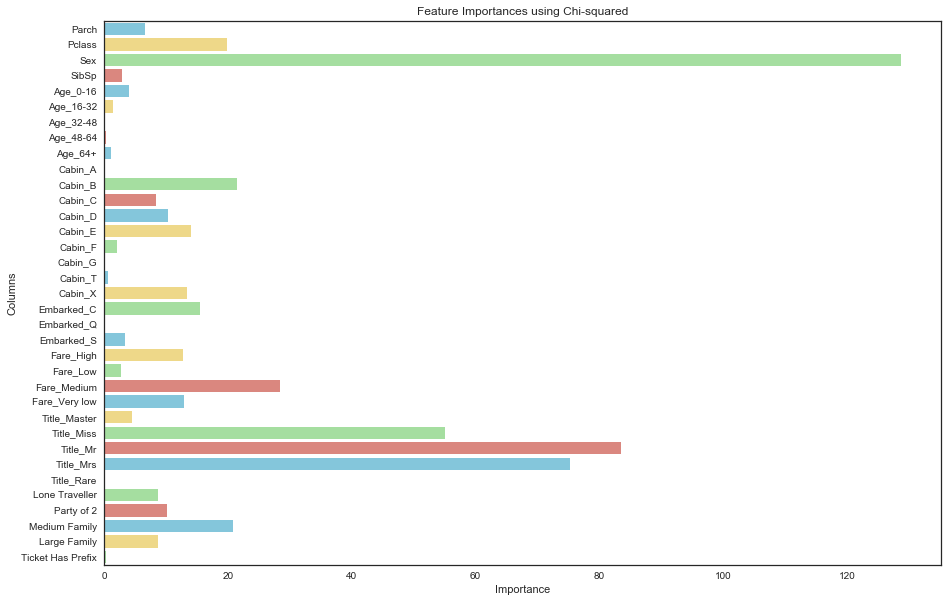

In [51]:
# Because the chi2 test will be the same for each model, we only need to run this test once.
# When we have established which features are the most important via this test, we can re-use this 
# reduced dataset for all other estimators without "feature_importances_"

# chi2 test of independence

# fit a model using a score function of chi2
Kbest = SelectKBest(score_func=chi2, k=10)
fit = Kbest.fit(X_train, Y_train)

# Create a table with the results and score for each features
scores = pd.DataFrame({'Columns': X_test.columns.values, 'Score': fit.scores_})

# Visualise the scores of dependence with a barplot
plt.subplots(figsize=(15, 10))
g = sns.barplot('Score','Columns',data = scores, palette=mycols,orient = "h")
g.set_xlabel("Importance")
g = g.set_title("Feature Importances using Chi-squared")

- 从这看出，**只有小部分特征比较重要**
- 低效的特征应该去除

In [52]:
# First I will take some copies of the original estimation, validation and test datasets
# so that we don't mess with these
chi2_reduced_train = X_train.copy()
chi2_reduced_test = X_test.copy()
chi2_reduced_final_test = test.copy()

# Now I will drop all of the columns that I deemed to be irrelevant
# I played with a variety of options here, but this is what I found to work best
drop = ['SibSp', 'Age_0-16', 'Age_16-32', 'Age_32-48', 'Age_48-64', 'Cabin_A', 'Cabin_F',
        'Cabin_G', 'Embarked_Q', 'Embarked_S', 'Fare_Low', 'Fare_Medium', 'Title_Rare',
        'Title_Master','Title_Rare', 'Ticket Has Prefix',
        'Age_64+', 'Cabin_A', 'Cabin_F', 'Cabin_G', 'Cabin_T']

# Reduce features of estimation, validation and test for use in modelling
chi2_reduced_train.drop(drop, axis = 1, inplace = True)
chi2_reduced_test.drop(drop, axis = 1, inplace = True)
chi2_reduced_final_test.drop(drop, axis = 1, inplace = True)

# You'll see that we now have just 18 features
print('X_train: ', chi2_reduced_train.shape, '\nX_test: ', chi2_reduced_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (668, 18) 
X_test:  (223, 18) 
Y_train:  (668,) 
Y_test:  (223,)


### Extra Trees reduction

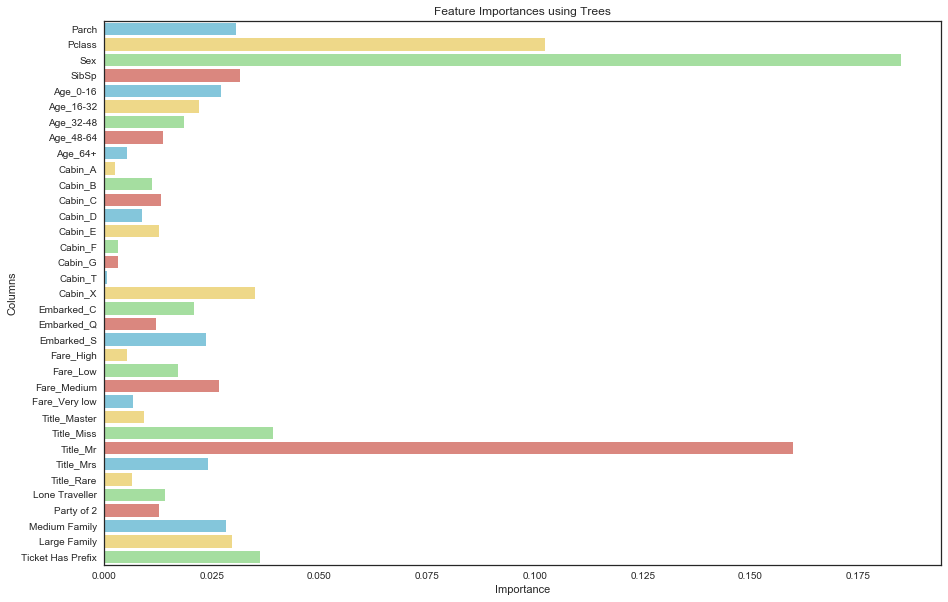

In [53]:
# Now I will do the same for the extra trees method of feature reduction
# Which once again, can be reused for estimators that do not have the feature_importances_ attribute

# First, let's fit a model using the extra trees classifier
model = ExtraTreesClassifier()
model.fit(X_train, Y_train)

# And create a table with the importances
scores = pd.DataFrame({'Columns': X_test.columns.values, 'Score': model.feature_importances_})
scores.sort_values(by='Score', ascending=False)

# Finally let's visualise this
plt.subplots(figsize=(15, 10))
g = sns.barplot('Score','Columns',data = scores, palette=mycols,orient = "h")
g.set_xlabel("Importance")
g = g.set_title("Feature Importances using Trees")

- 通过卡方测试, 可以看出 **更多有效特征**，比如 "Sex" 和 "Title"。

In [54]:
# In a similar fashion, I will reduce the estimation, validation and test datasets according to
# the extra trees feature importances.

# Take another copy
etc_reduced_train = X_train.copy()
etc_reduced_test = X_test.copy()
etc_reduced_final_test = test.copy()

# Once again, I tried a few options here of which features the drop. I decided these were the best choice.
drop = ['Age_0-16', 'Age_16-32', 'Age_48-64', 'Age_64+', 'Cabin_A', 'Cabin_B',
        'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G','Cabin_T',
        'Embarked_Q', 'Title_Rare']

# Reduce features of estimation, validation and test datasets
etc_reduced_train.drop(drop, axis = 1, inplace = True)
etc_reduced_test.drop(drop, axis = 1, inplace = True)
etc_reduced_final_test.drop(drop, axis = 1, inplace = True)

# Let's see the new shape of the data
print('X_train: ', etc_reduced_train.shape, '\nX_test: ', etc_reduced_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (668, 21) 
X_test:  (223, 21) 
Y_train:  (668,) 
Y_test:  (223,)


- 特征缩减方法: feature\__importances_ and RFE, 在建模过程中完成。
- 完成以上工作后，**可以开始建模了**。

### ***K-Nearest Neighbours***

- 没有可用的 feature\__importances_ attribute, 我们选择 **卡方和 extra trees缩减数据集**。

In [55]:
# KNN - chi-squared
knn = KNeighborsClassifier()

# Fit estimator to reduced dataset
knn.fit(chi2_reduced_train, Y_train)

# Compute cross validated scores and take the mean
knn_scores = cross_val_score(knn, chi2_reduced_train, Y_train, cv = shuff)
knn_scores = knn_scores.mean()

print('Chi2 - Mean Cross Validated Score: {:.2f}'. format(knn_scores*100))
knn_apply_acc = metrics.accuracy_score(Y_test, knn.predict(chi2_reduced_test))
print('Chi2 - Accuracy when applied to Test: {:.2f}'. format(knn_apply_acc*100))
print("-"*50)

##############################################################################

# KNN - extra trees
knn = KNeighborsClassifier()

# Fit estimator to reduced dataset
knn.fit(etc_reduced_train, Y_train)

# Compute cross validated scores and take the mean
knn_scores = cross_val_score(knn, etc_reduced_train, Y_train, cv = shuff)
knn_scores = knn_scores.mean()
print('Extra Trees - Mean Cross Validated Score: {:.2f}'. format(knn_scores*100))
knn_apply_acc = metrics.accuracy_score(Y_test, knn.predict(etc_reduced_test))
print('Extra Trees - Accuracy when applied to Test: {:.2f}'. format(knn_apply_acc*100))

Chi2 - Mean Cross Validated Score: 81.84
Chi2 - Accuracy when applied to Test: 80.27
--------------------------------------------------
Extra Trees - Mean Cross Validated Score: 81.84
Extra Trees - Accuracy when applied to Test: 82.06


### ***Support Vector Machine***

- 没有可用的 feature\__importances_ attribute, 我们选择 **卡方和 extra trees缩减数据集**。

In [56]:
# SVM - chi-squared
svc = SVC()

# Fit estimator to reduced dataset
svc.fit(chi2_reduced_train, Y_train)
        
# Compute cross validated scores and take the mean
svc_scores = cross_val_score(svc, chi2_reduced_train, Y_train, cv = shuff)
svc_scores = svc_scores.mean()
        
print('Chi2 - Mean Cross Validated Score: {:.2f}'. format(svc_scores*100))
svc_apply_acc = metrics.accuracy_score(Y_test, svc.predict(chi2_reduced_test))
print('Chi2 - Accuracy when applied to Test: {:.2f}'. format(svc_apply_acc*100))
print("-"*50)

##############################################################################

# SVM - extra trees
svc = SVC()

# Fit estimator to reduced dataset
svc.fit(etc_reduced_train, Y_train)
        
# Compute cross validated scores and take the mean
svc_scores = cross_val_score(svc, etc_reduced_train, Y_train, cv = shuff)
svc_scores = svc_scores.mean()
        
print('Extra Trees - Mean Cross Validated Score: {:.2f}'. format(svc_scores*100))
svc_apply_acc = metrics.accuracy_score(Y_test, svc.predict(etc_reduced_test))
print('Extra Trees - Accuracy when applied to Test: {:.2f}'. format(svc_apply_acc*100)) 

Chi2 - Mean Cross Validated Score: 81.59
Chi2 - Accuracy when applied to Test: 81.61
--------------------------------------------------
Extra Trees - Mean Cross Validated Score: 82.09
Extra Trees - Accuracy when applied to Test: 83.86


### ***Gradient Boosting Classifier***

- 这个预测模型包含 **"feature__importances_"** , 因此我们可以使用它和**RFECV**.

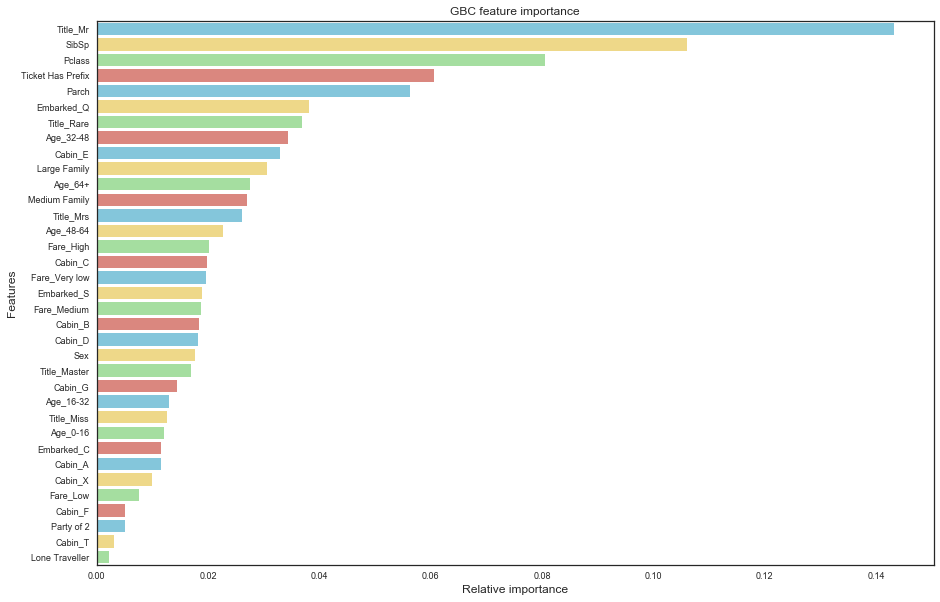

In [57]:
# Sort feature importances from GBC model trained earlier
indices = np.argsort(gbc.feature_importances_)[::-1]

# Visualise these with a barplot
plt.subplots(figsize=(15, 10))
g = sns.barplot(y=X_train.columns[indices], x = gbc.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("GBC feature importance");

In [58]:
# Take some copies
gbc_red_train = X_train.copy()
gbc_red_test = X_test.copy()
gbc_final_test = test.copy()

# Fit a model to the estimation data
gbc = gbc.fit(gbc_red_train, Y_train)

# Allow the feature importances attribute to select the most important features
gbc_feat_red = SelectFromModel(gbc, prefit = True)

# Reduce estimation, validation and test datasets
gbc_X_train = gbc_feat_red.transform(gbc_red_train)
gbc_X_test = gbc_feat_red.transform(gbc_red_test)
gbc_final_test = gbc_feat_red.transform(gbc_final_test)

print("Results of 'feature_importances_':")
print('X_train: ', gbc_X_train.shape, '\nX_test: ', gbc_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)
print("-"*75)

##############################################################################

# Take come copies
gbc_rfecv_train = X_train.copy()
gbc_rfecv_test = X_test.copy()
gbc_rfecv_final_test = test.copy()

# Initialise RFECV
gbc_rfecv = RFECV(estimator = gbc, step = 1, cv = shuff, scoring = 'accuracy')

# Fit RFECV to the estimation data
gbc_rfecv.fit(gbc_rfecv_train, Y_train)

# Now reduce estimation, validation and test datasets
gbc_rfecv_X_train = gbc_rfecv.transform(gbc_rfecv_train)
gbc_rfecv_X_test = gbc_rfecv.transform(gbc_rfecv_test)
gbc_rfecv_final_test = gbc_rfecv.transform(gbc_rfecv_final_test)

print("Results of 'RFECV':")

# Let's see the results of RFECV
print(gbc_rfecv.support_)
print(gbc_rfecv.ranking_)

print('X_train: ', gbc_rfecv_X_train.shape, '\nX_test: ', gbc_rfecv_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

Results of 'feature_importances_':
X_train:  (668, 10) 
X_test:  (223, 10) 
Y_train:  (668,) 
Y_test:  (223,)
---------------------------------------------------------------------------
Results of 'RFECV':
[ True  True False  True  True False False False False False False  True
 False False False False False False False  True False False False False
 False False False  True False  True False False False False False]
[ 1  1 14  1  1  3 19 17  9 18 12  1  4  7 26  5 27 24 21  1 13 10 25  8
 16 11 22  1  6  1 28 23 15 20  2]
X_train:  (668, 8) 
X_test:  (223, 8) 
Y_train:  (668,) 
Y_test:  (223,)


In [59]:
# GBC - feature_importances_
gbc = GradientBoostingClassifier(random_state=0)

# Fit estimator to reduced dataset
gbc.fit(gbc_X_train, Y_train)

# Compute cross validated scores and take the mean
gbc_scores = cross_val_score(gbc, gbc_X_train, Y_train, cv = shuff)
gbc_scores = gbc_scores.mean()

print('feature_importances_ - Mean Cross Validated Score: {:.2f}'. format(gbc_scores*100))
gbc_apply_acc = metrics.accuracy_score(Y_test, gbc.predict(gbc_X_test))
print('feature_importances_ - Accuracy when applied to Test: {:.2f}'. format(gbc_apply_acc*100))
print("-"*50)

##############################################################################

# GBC - RFECV
gbc = GradientBoostingClassifier(random_state=0)

# Fit estimator to reduced dataset
gbc.fit(gbc_rfecv_X_train, Y_train)

# Compute cross validated scores and take the mean
gbc_scores = cross_val_score(gbc, gbc_rfecv_X_train, Y_train, cv = shuff)
gbc_scores = gbc_scores.mean()

print('RFECV - Mean Cross Validated Score: {:.2f}'. format(gbc_scores*100))
gbc_apply_acc = metrics.accuracy_score(Y_test, gbc.predict(gbc_rfecv_X_test))
print('RFECV - Accuracy when applied to Test: {:.2f}'. format(gbc_apply_acc*100))

feature_importances_ - Mean Cross Validated Score: 83.08
feature_importances_ - Accuracy when applied to Test: 84.30
--------------------------------------------------
RFECV - Mean Cross Validated Score: 82.59
RFECV - Accuracy when applied to Test: 82.06


### ***XGBoost***

- 这个预测模型包含 **"feature__importances_"** , 因此我们可以使用它和**RFECV**.

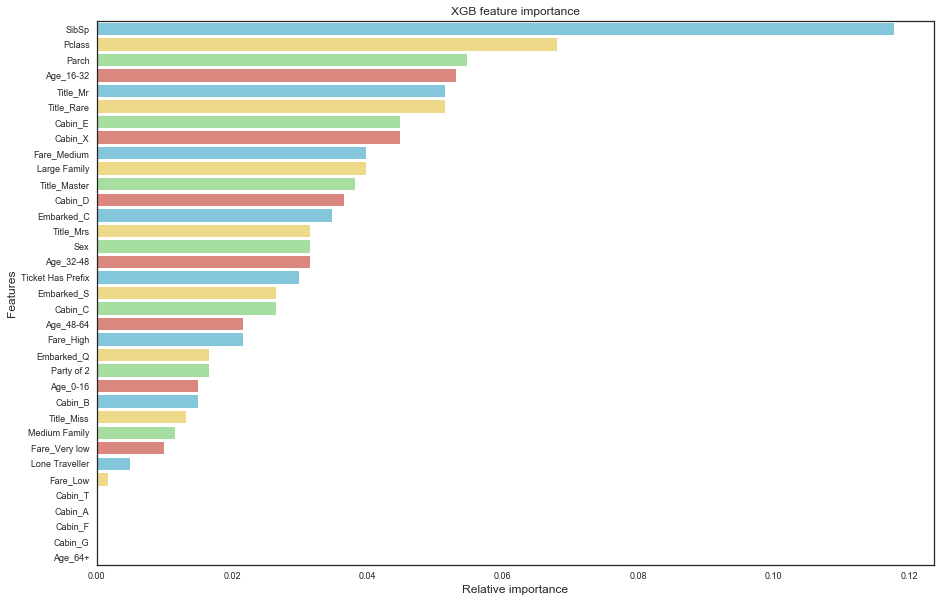

In [60]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(xgb.feature_importances_)[::-1]

# Visualise these with a barplot
plt.subplots(figsize=(15, 10))
g = sns.barplot(y=X_train.columns[indices], x = xgb.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

In [61]:
# Take some copies
xgb_red_train = X_train.copy()
xgb_red_test = X_test.copy()
xgb_final_test = test.copy()

# Fit a model to the estimation data
xgb = xgb.fit(xgb_red_train, Y_train)

# Allow the feature importances attribute to select the most important features
xgb_feat_red = SelectFromModel(xgb, prefit = True)

# Reduce estimation, validation and test datasets
xgb_X_train = xgb_feat_red.transform(xgb_red_train)
xgb_X_test = xgb_feat_red.transform(xgb_red_test)
xgb_final_test = xgb_feat_red.transform(xgb_final_test)

print("Results of 'feature_importances_':")
print('X_train: ', xgb_X_train.shape, '\nX_test: ', xgb_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)
print("-"*75)

##############################################################################

# Take come copies
xgb_rfecv_train = X_train.copy()
xgb_rfecv_test = X_test.copy()
xgb_rfecv_final_test = test.copy()

# Initialise RFECV
xgb_rfecv = RFECV(estimator = xgb, step = 1, cv = shuff, scoring = 'accuracy')

# Fit RFECV to the estimation data
xgb_rfecv.fit(xgb_rfecv_train, Y_train)

# Now reduce estimation, validation and test datasets
xgb_rfecv_X_train = xgb_rfecv.transform(xgb_rfecv_train)
xgb_rfecv_X_test = xgb_rfecv.transform(xgb_rfecv_test)
xgb_rfecv_final_test = xgb_rfecv.transform(xgb_rfecv_final_test)

print("Results of 'RFECV':")

# Let's see the results of RFECV
print(xgb_rfecv.support_)
print(xgb_rfecv.ranking_)

print('X_train: ', xgb_rfecv_X_train.shape, '\nX_test: ', xgb_rfecv_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

Results of 'feature_importances_':
X_train:  (668, 17) 
X_test:  (223, 17) 
Y_train:  (668,) 
Y_test:  (223,)
---------------------------------------------------------------------------


D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

Results of 'RFECV':
[ True  True  True  True  True  True  True False False False False  True
  True  True False False False  True  True  True  True False False  True
 False  True False  True  True  True False False False  True  True]
[ 1  1  1  1  1  1  1  4 15 14  6  1  1  1 11 12 13  1  1  1  1  7 10  1
  5  1  2  1  1  1  9  3  8  1  1]
X_train:  (668, 21) 
X_test:  (223, 21) 
Y_train:  (668,) 
Y_test:  (223,)


In [62]:
# XGB - feature_importances_
xgb = XGBClassifier()

# Fit estimator to reduced dataset
xgb.fit(xgb_X_train, Y_train)

# Compute cross validated scores and take the mean
xgb_scores = cross_val_score(xgb, xgb_X_train, Y_train, cv = shuff)
xgb_scores = xgb_scores.mean()

print('feature_importances_ - Mean Cross Validated Score: {:.2f}'. format(xgb_scores*100))
xgb_apply_acc = metrics.accuracy_score(Y_test, xgb.predict(xgb_X_test))
print('feature_importances_ - Accuracy when applied to Test: {:.2f}'. format(xgb_apply_acc*100))
print("-"*50)

##############################################################################

# XGB - RFECV
xgb = XGBClassifier()

# Fit estimator to reduced dataset
xgb.fit(xgb_rfecv_X_train, Y_train)

# Compute cross validated scores and take the mean
xgb_scores = cross_val_score(xgb, xgb_rfecv_X_train, Y_train, cv = shuff)
xgb_scores = xgb_scores.mean()

print('RFECV - Mean Cross Validated Score: {:.2f}'. format(xgb_scores*100))
xgb_apply_acc = metrics.accuracy_score(Y_test, xgb.predict(xgb_rfecv_X_test))
print('RFECV - Accuracy when applied to Test: {:.2f}'. format(xgb_apply_acc*100))

feature_importances_ - Mean Cross Validated Score: 83.08
feature_importances_ - Accuracy when applied to Test: 82.06
--------------------------------------------------
RFECV - Mean Cross Validated Score: 82.59
RFECV - Accuracy when applied to Test: 81.61


D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

### ***Multi Layer Perceptron***


- 没有可用的 feature\__importances_ attribute, 我们选择 **卡方和 extra trees缩减数据集**。

In [64]:
# MLP - chi-squared
mlp = MLPClassifier()

# Fit estimator to reduced dataset
mlp.fit(chi2_reduced_train, Y_train)

# Compute cross validated scores and take the mean
mlp_scores = cross_val_score(mlp, chi2_reduced_train, Y_train, cv = shuff)
mlp_scores = mlp_scores.mean()

print('Chi2 - Mean Cross Validated Score: {:.2f}'. format(mlp_scores*100))
mlp_apply_acc = metrics.accuracy_score(Y_test, mlp.predict(chi2_reduced_test))
print('Chi2 - Accuracy when applied to Test: {:.2f}'. format(mlp_apply_acc*100))
print("-"*50)

##############################################################################

# MLP - extra trees
mlp = MLPClassifier()

# Fit estimator to reduced dataset
mlp.fit(etc_reduced_train, Y_train)

# Compute cross validated scores and take the mean
mlp_scores = cross_val_score(mlp, etc_reduced_train, Y_train, cv = shuff)
mlp_scores = mlp_scores.mean()
print('Extra Trees - Mean Cross Validated Score: {:.2f}'. format(mlp_scores*100))
mlp_apply_acc = metrics.accuracy_score(Y_test, mlp.predict(etc_reduced_test))
print('Extra Trees - Accuracy when applied to Test: {:.2f}'. format(mlp_apply_acc*100))

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Chi2 - Mean Cross Validated Score: 82.34
Chi2 - Accuracy when applied to Test: 80.27
--------------------------------------------------


D:\Anaconda2\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Extra Trees - Mean Cross Validated Score: 83.08
Extra Trees - Accuracy when applied to Test: 81.61


D:\Anaconda2\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### ***Linear Support Vector Machine***


- 没有可用的 feature\__importances_ attribute, 我们选择 **卡方和 extra trees缩减数据集**。

In [65]:
# LSVC - chi-squared
lsvc = LinearSVC()

# Fit estimator to reduced dataset
lsvc.fit(chi2_reduced_train, Y_train)

# Compute cross validated scores and take the mean
lsvc_scores = cross_val_score(lsvc, chi2_reduced_train, Y_train, cv = shuff)
lsvc_scores = lsvc_scores.mean()

print('Chi2 - Mean Cross Validated Score: {:.2f}'. format(lsvc_scores*100))
lsvc_apply_acc = metrics.accuracy_score(Y_test, lsvc.predict(chi2_reduced_test))
print('Chi2 - Accuracy when applied to Test: {:.2f}'. format(lsvc_apply_acc*100))
print("-"*50)

##############################################################################

# LSVC - extra trees
lsvc = LinearSVC()

# Fit estimator to reduced dataset
lsvc.fit(etc_reduced_train, Y_train)

# Compute cross validated scores and take the mean
lsvc_scores = cross_val_score(lsvc, etc_reduced_train, Y_train, cv = shuff)
lsvc_scores = lsvc_scores.mean()
print('Extra Trees - Mean Cross Validated Score: {:.2f}'. format(lsvc_scores*100))
lsvc_apply_acc = metrics.accuracy_score(Y_test, lsvc.predict(etc_reduced_test))
print('Extra Trees - Accuracy when applied to Test: {:.2f}'. format(lsvc_apply_acc*100))

Chi2 - Mean Cross Validated Score: 81.59
Chi2 - Accuracy when applied to Test: 81.17
--------------------------------------------------
Extra Trees - Mean Cross Validated Score: 84.08
Extra Trees - Accuracy when applied to Test: 82.96


### ***Random Forest***

- 这个预测模型包含 **"feature__importances_"** , 因此我们可以使用它和**RFECV**.

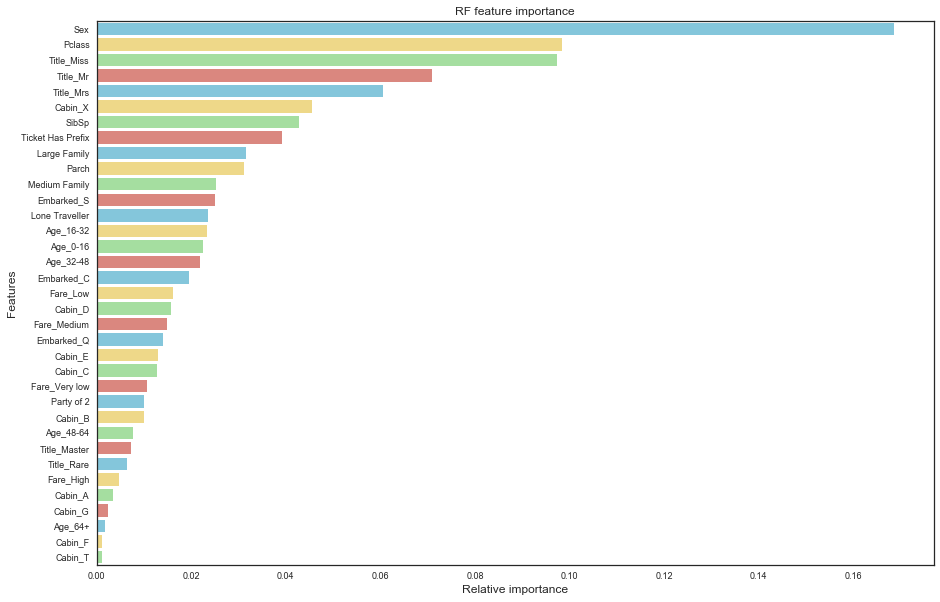

In [66]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(rf.feature_importances_)[::-1]

# Visualise these with a barplot
plt.subplots(figsize=(15, 10))
g = sns.barplot(y=X_train.columns[indices], x = rf.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("RF feature importance");

In [67]:
# Take some copies
rf_red_train = X_train.copy()
rf_red_test = X_test.copy()
rf_final_test = test.copy()

# Fit a model to the estimation data
rf = rf.fit(rf_red_train, Y_train)

# Allow the feature importances attribute to select the most important features
rf_feat_red = SelectFromModel(rf, prefit = True)

# Reduce estimation, validation and test datasets
rf_X_train = rf_feat_red.transform(rf_red_train)
rf_X_test = rf_feat_red.transform(rf_red_test)
rf_final_test = rf_feat_red.transform(rf_final_test)

print("Results of 'feature_importances_':")
print('X_train: ', rf_X_train.shape, '\nX_test: ', rf_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)
print("-"*75)

##############################################################################

# Take come copies
rf_rfecv_train = X_train.copy()
rf_rfecv_test = X_test.copy()
rf_rfecv_final_test = test.copy()

# Initialise RFECV
rf_rfecv = RFECV(estimator = rf, step = 1, cv = shuff, scoring = 'accuracy')

# Fit RFECV to the estimation data
rf_rfecv.fit(rf_rfecv_train, Y_train)

# Now reduce estimation, validation and test datasets
rf_rfecv_X_train = rf_rfecv.transform(rf_rfecv_train)
rf_rfecv_X_test = rf_rfecv.transform(rf_rfecv_test)
rf_rfecv_final_test = rf_rfecv.transform(rf_rfecv_final_test)

print("Results of 'RFECV':")

# Let's see the results of RFECV
print(rf_rfecv.support_)
print(rf_rfecv.ranking_)

print('X_train: ', rf_rfecv_X_train.shape, '\nX_test: ', rf_rfecv_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

Results of 'feature_importances_':
X_train:  (668, 8) 
X_test:  (223, 8) 
Y_train:  (668,) 
Y_test:  (223,)
---------------------------------------------------------------------------
Results of 'RFECV':
[ True  True  True  True False False False False False False False False
 False False False False False  True False False False False False False
 False False False  True  True False False False False False False]
[ 1  1  1  1  6  7 12 18 21 27 20 14 24 13 28 26 29  1  9 15 11 23  8  4
 17 22  3  1  1 25 16 19 10  2  5]
X_train:  (668, 7) 
X_test:  (223, 7) 
Y_train:  (668,) 
Y_test:  (223,)


In [68]:
# RF - feature_importances_
rf = RandomForestClassifier()

# Fit estimator to reduced dataset
rf.fit(rf_X_train, Y_train)

# Compute cross validated scores and take the mean
rf_scores = cross_val_score(rf, rf_X_train, Y_train, cv = shuff)
rf_scores = rf_scores.mean()

print('feature_importances_ - Mean Cross Validated Score: {:.2f}'. format(rf_scores*100))
rf_apply_acc = metrics.accuracy_score(Y_test, rf.predict(rf_X_test))
print('feature_importances_ - Accuracy when applied to Test: {:.2f}'. format(rf_apply_acc*100))
print("-"*50)

##############################################################################

# RF - RFECV
rf = RandomForestClassifier()

# Fit estimator to reduced dataset
rf.fit(rf_rfecv_X_train, Y_train)

# Compute cross validated scores and take the mean
rf_scores = cross_val_score(rf, rf_rfecv_X_train, Y_train, cv = shuff)
rf_scores = rf_scores.mean()

print('RFECV - Mean Cross Validated Score: {:.2f}'. format(rf_scores*100))
rf_apply_acc = metrics.accuracy_score(Y_test, rf.predict(rf_rfecv_X_test))
print('RFECV - Accuracy when applied to Test: {:.2f}'. format(rf_apply_acc*100))

feature_importances_ - Mean Cross Validated Score: 80.85
feature_importances_ - Accuracy when applied to Test: 78.92
--------------------------------------------------
RFECV - Mean Cross Validated Score: 83.33
RFECV - Accuracy when applied to Test: 79.82


### ***Logistic Regression***

- 没有可用的 feature\__importances_ attribute, 我们选择 **卡方和 extra trees缩减数据集**。

In [69]:
# LR - chi-squared
lr = LogisticRegression()

# Fit estimator to reduced dataset
lr.fit(chi2_reduced_train, Y_train)

# Compute cross validated scores and take the mean
lr_scores = cross_val_score(lr, chi2_reduced_train, Y_train, cv = shuff)
lr_scores = lr_scores.mean()

print('Chi2 - Mean Cross Validated Score: {:.2f}'. format(lr_scores*100))
lr_apply_acc = metrics.accuracy_score(Y_test, lr.predict(chi2_reduced_test))
print('Chi2 - Accuracy when applied to Test: {:.2f}'. format(lr_apply_acc*100))
print("-"*50)

##############################################################################

# LR - extra trees
lr = LogisticRegression()

# Fit estimator to reduced dataset
lr.fit(etc_reduced_train, Y_train)

# Compute cross validated scores and take the mean
lr_scores = cross_val_score(lr, etc_reduced_train, Y_train, cv = shuff)
lr_scores = lr_scores.mean()
print('Extra Trees - Mean Cross Validated Score: {:.2f}'. format(lr_scores*100))
lr_apply_acc = metrics.accuracy_score(Y_test, lr.predict(etc_reduced_test))
print('Extra Trees - Accuracy when applied to Test: {:.2f}'. format(lr_apply_acc*100))

Chi2 - Mean Cross Validated Score: 81.34
Chi2 - Accuracy when applied to Test: 79.82
--------------------------------------------------
Extra Trees - Mean Cross Validated Score: 84.33
Extra Trees - Accuracy when applied to Test: 81.61


### ***Decision Tree***

- 这个预测模型包含 **"feature__importances_"** , 因此我们可以使用它和**RFECV**.

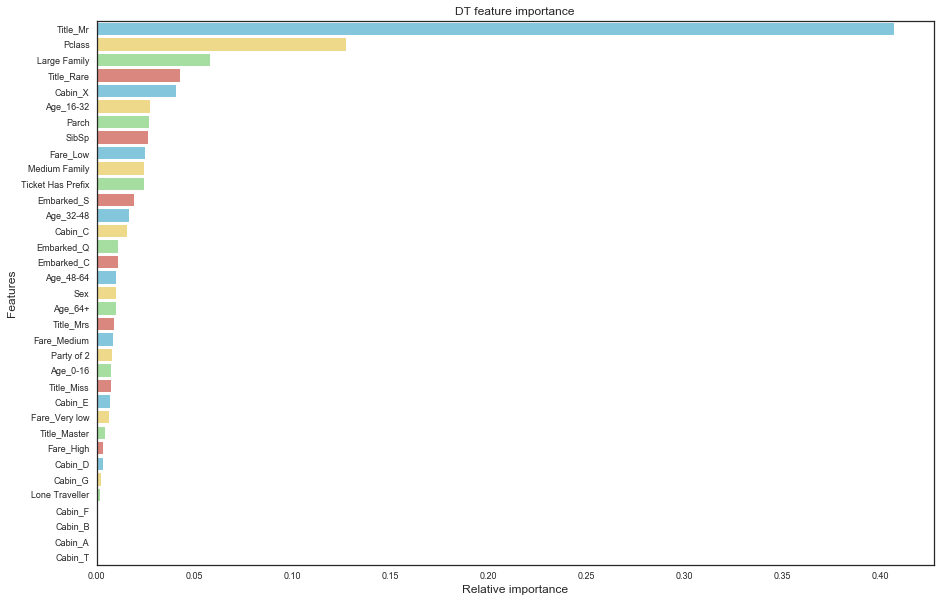

In [70]:
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(dt.feature_importances_)[::-1]

# Visualise these with a barplot
plt.subplots(figsize=(15, 10))
g = sns.barplot(y=X_train.columns[indices], x = dt.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("DT feature importance");

In [71]:
# Take some copies
dt_red_train = X_train.copy()
dt_red_test = X_test.copy()
dt_final_test = test.copy()

# Fit a model to the estimation data
dt = dt.fit(dt_red_train, Y_train)

# Allow the feature importances attribute to select the most important features
dt_feat_red = SelectFromModel(dt, prefit = True)

# Reduce estimation, validation and test datasets
dt_X_train = dt_feat_red.transform(dt_red_train)
dt_X_test = dt_feat_red.transform(dt_red_test)
dt_final_test = dt_feat_red.transform(dt_final_test)

print("Results of 'feature_importances_':")
print('X_train: ', dt_X_train.shape, '\nX_test: ', dt_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)
print("-"*75)

##############################################################################

# Take come copies
dt_rfecv_train = X_train.copy()
dt_rfecv_test = X_test.copy()
dt_rfecv_final_test = test.copy()

# Initialise RFECV
dt_rfecv = RFECV(estimator = dt, step = 1, cv = shuff, scoring = 'accuracy')

# Fit RFECV to the estimation data
dt_rfecv.fit(dt_rfecv_train, Y_train)

# Now reduce estimation, validation and test datasets
dt_rfecv_X_train = dt_rfecv.transform(dt_rfecv_train)
dt_rfecv_X_test = dt_rfecv.transform(dt_rfecv_test)
dt_rfecv_final_test = dt_rfecv.transform(dt_rfecv_final_test)

print("Results of 'RFECV':")

# Let's see the results of RFECV
print(dt_rfecv.support_)
print(dt_rfecv.ranking_)

print('X_train: ', dt_rfecv_X_train.shape, '\nX_test: ', dt_rfecv_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

Results of 'feature_importances_':
X_train:  (668, 6) 
X_test:  (223, 6) 
Y_train:  (668,) 
Y_test:  (223,)
---------------------------------------------------------------------------
Results of 'RFECV':
[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False False False  True False]
[ 5  1 30  4 26  6 19 13 20 27 24 10 25 22 29 28 31  2 11 18  7 32  3 16
 23 14 21  1 12  1 17 15  9  1  8]
X_train:  (668, 4) 
X_test:  (223, 4) 
Y_train:  (668,) 
Y_test:  (223,)


In [72]:
# DT - feature_importances_
dt = DecisionTreeClassifier()

# Fit estimator to reduced dataset
dt.fit(dt_X_train, Y_train)

# Compute cross validated scores and take the mean
dt_scores = cross_val_score(dt, dt_X_train, Y_train, cv = shuff)
dt_scores = dt_scores.mean()

print('feature_importances_ - Mean Cross Validated Score: {:.2f}'. format(dt_scores*100))
dt_apply_acc = metrics.accuracy_score(Y_test, dt.predict(dt_X_test))
print('feature_importances_ - Accuracy when applied to Test: {:.2f}'. format(dt_apply_acc*100))
print("-"*50)

##############################################################################

# DT - RFECV
dt = DecisionTreeClassifier()

# Fit estimator to reduced dataset
dt.fit(dt_rfecv_X_train, Y_train)

# Compute cross validated scores and take the mean
dt_scores = cross_val_score(dt, dt_rfecv_X_train, Y_train, cv = shuff)
dt_scores = dt_scores.mean()

print('RFECV - Mean Cross Validated Score: {:.2f}'. format(dt_scores*100))
dt_apply_acc = metrics.accuracy_score(Y_test, dt.predict(dt_rfecv_X_test))
print('RFECV - Accuracy when applied to Test: {:.2f}'. format(dt_apply_acc*100))

feature_importances_ - Mean Cross Validated Score: 82.34
feature_importances_ - Accuracy when applied to Test: 82.51
--------------------------------------------------
RFECV - Mean Cross Validated Score: 84.08
RFECV - Accuracy when applied to Test: 82.51


### ***Adaboost***

- 这个预测模型包含 **"feature__importances_"** , 因此我们可以使用它和**RFECV**.

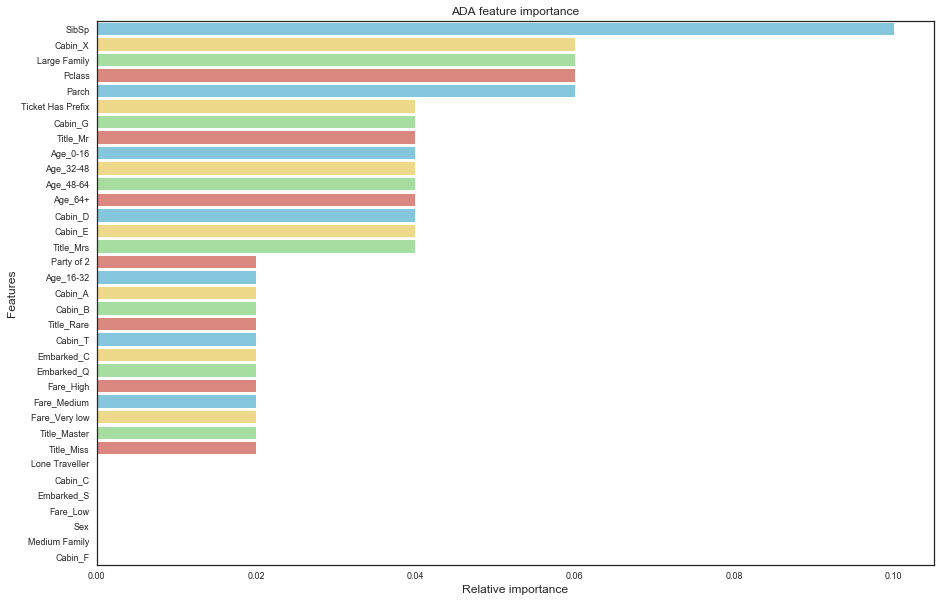

In [74]:
ada = AdaBoostClassifier()
ada.fit(X_train, Y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(ada.feature_importances_)[::-1]

# Visualise these with a barplot
plt.subplots(figsize=(15, 10))
g = sns.barplot(y=X_train.columns[indices], x = ada.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("ADA feature importance");

In [75]:
# Take some copies
ada_red_train = X_train.copy()
ada_red_test = X_test.copy()
ada_final_test = test.copy()

# Fit a model to the estimation data
ada = ada.fit(ada_red_train, Y_train)

# Allow the feature importances attribute to select the most important features
ada_feat_red = SelectFromModel(ada, prefit = True)

# Reduce estimation, validation and test datasets
ada_X_train = ada_feat_red.transform(ada_red_train)
ada_X_test = ada_feat_red.transform(ada_red_test)
ada_final_test = ada_feat_red.transform(ada_final_test)

print("Results of 'feature_importances_':")
print('X_train: ', ada_X_train.shape, '\nX_test: ', ada_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)
print("-"*75)

##############################################################################

# Take come copies
ada_rfecv_train = X_train.copy()
ada_rfecv_test = X_test.copy()
ada_rfecv_final_test = test.copy()

# Initialise RFECV
ada_rfecv = RFECV(estimator = ada, step = 1, cv = shuff, scoring = 'accuracy')

# Fit RFECV to the estimation data
ada_rfecv.fit(ada_rfecv_train, Y_train)

# Now reduce estimation, validation and test datasets
ada_rfecv_X_train = ada_rfecv.transform(ada_rfecv_train)
ada_rfecv_X_test = ada_rfecv.transform(ada_rfecv_test)
ada_rfecv_final_test = ada_rfecv.transform(ada_rfecv_final_test)

print("Results of 'RFECV':")

# Let's see the results of RFECV
print(ada_rfecv.support_)
print(ada_rfecv.ranking_)

print('X_train: ', ada_rfecv_X_train.shape, '\nX_test: ', ada_rfecv_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

Results of 'feature_importances_':
X_train:  (668, 15) 
X_test:  (223, 15) 
Y_train:  (668,) 
Y_test:  (223,)
---------------------------------------------------------------------------
Results of 'RFECV':
[ True  True False  True  True False  True  True  True  True  True False
  True  True False  True False  True  True  True False  True False  True
  True  True  True  True  True False False False False  True  True]
[ 1  1  9  1  1  4  1  1  1  1  1  6  1  1 12  1  5  1  1  1 11  1  7  1
  1  1  1  1  1  2  8  3 10  1  1]
X_train:  (668, 24) 
X_test:  (223, 24) 
Y_train:  (668,) 
Y_test:  (223,)


In [76]:
# ADA - feature_importances_
ada = AdaBoostClassifier()

# Fit estimator to reduced dataset
ada.fit(ada_X_train, Y_train)

# Compute cross validated scores and take the mean
ada_scores = cross_val_score(ada, ada_X_train, Y_train, cv = shuff)
ada_scores = ada_scores.mean()

print('feature_importances_ - Mean Cross Validated Score: {:.2f}'. format(ada_scores*100))
ada_apply_acc = metrics.accuracy_score(Y_test, ada.predict(ada_X_test))
print('feature_importances_ - Accuracy when applied to Test: {:.2f}'. format(ada_apply_acc*100))
print("-"*50)

##############################################################################

# ADA - RFECV
ada = AdaBoostClassifier()

# Fit estimator to reduced dataset
ada.fit(ada_rfecv_X_train, Y_train)

# Compute cross validated scores and take the mean
ada_scores = cross_val_score(ada, ada_rfecv_X_train, Y_train, cv = shuff)
ada_scores = ada_scores.mean()

print('RFECV - Mean Cross Validated Score: {:.2f}'. format(ada_scores*100))
ada_apply_acc = metrics.accuracy_score(Y_test, ada.predict(ada_rfecv_X_test))
print('RFECV - Accuracy when applied to Test: {:.2f}'. format(ada_apply_acc*100))

feature_importances_ - Mean Cross Validated Score: 84.33
feature_importances_ - Accuracy when applied to Test: 79.82
--------------------------------------------------
RFECV - Mean Cross Validated Score: 84.58
RFECV - Accuracy when applied to Test: 79.37


### ***Extra Trees***

- 这个预测模型包含 **"feature__importances_"** , 因此我们可以使用它和**RFECV**.

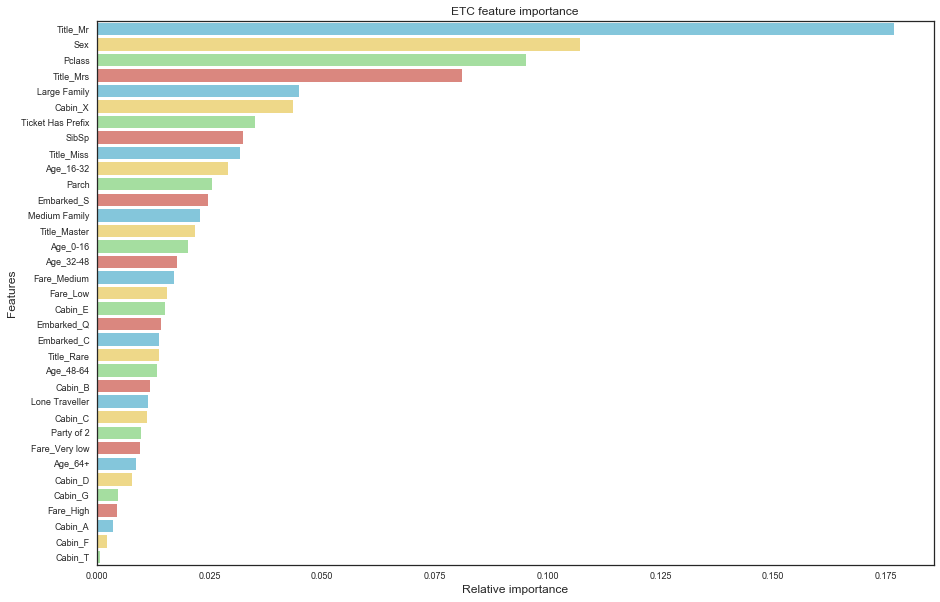

In [77]:
etc = ExtraTreesClassifier()
etc.fit(X_train, Y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(etc.feature_importances_)[::-1]

# Visualise these with a barplot
plt.subplots(figsize=(15, 10))
g = sns.barplot(y=X_train.columns[indices], x = etc.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("ETC feature importance");

In [78]:
# Take some copies
etc_red_train = X_train.copy()
etc_red_test = X_test.copy()
etc_final_test = test.copy()

# Fit a model to the estimation data
etc = etc.fit(etc_red_train, Y_train)

# Allow the feature importances attribute to select the most important features
etc_feat_red = SelectFromModel(etc, prefit = True)

# Reduce estimation, validation and test datasets
etc_X_train = etc_feat_red.transform(etc_red_train)
etc_X_test = etc_feat_red.transform(etc_red_test)
etc_final_test = etc_feat_red.transform(etc_final_test)

print("Results of 'feature_importances_':")
print('X_train: ', etc_X_train.shape, '\nX_test: ', etc_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)
print("-"*75)

##############################################################################

# Take come copies
etc_rfecv_train = X_train.copy()
etc_rfecv_test = X_test.copy()
etc_rfecv_final_test = test.copy()

# Initialise RFECV
etc_rfecv = RFECV(estimator = etc, step = 1, cv = shuff, scoring = 'accuracy')

# Fit RFECV to the estimation data
etc_rfecv.fit(etc_rfecv_train, Y_train)

# Now reduce estimation, validation and test datasets
etc_rfecv_X_train = etc_rfecv.transform(etc_rfecv_train)
etc_rfecv_X_test = etc_rfecv.transform(etc_rfecv_test)
etc_rfecv_final_test = etc_rfecv.transform(etc_rfecv_final_test)

print("Results of 'RFECV':")

# Let's see the results of RFECV
print(etc_rfecv.support_)
print(etc_rfecv.ranking_)

print('X_train: ', etc_rfecv_X_train.shape, '\nX_test: ', etc_rfecv_X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

Results of 'feature_importances_':
X_train:  (668, 11) 
X_test:  (223, 11) 
Y_train:  (668,) 
Y_test:  (223,)
---------------------------------------------------------------------------
Results of 'RFECV':
[ True  True  True  True False  True False False False False False False
 False False False False False  True False False  True False  True False
 False False False  True  True False False False  True  True  True]
[ 1  1  1  1  5  1  6 14 18 22  8 11 17  7 20 21 23  1  2 10  1 19  1  4
 16 13  3  1  1 15  9 12  1  1  1]
X_train:  (668, 13) 
X_test:  (223, 13) 
Y_train:  (668,) 
Y_test:  (223,)


In [79]:
# ETC - feature_importances_
etc = ExtraTreesClassifier()

# Fit estimator to reduced dataset
etc.fit(etc_X_train, Y_train)

# Compute cross validated scores and take the mean
etc_scores = cross_val_score(etc, etc_X_train, Y_train, cv = shuff)
etc_scores = etc_scores.mean()

print('feature_importances_ - Mean Cross Validated Score: {:.2f}'. format(etc_scores*100))
etc_apply_acc = metrics.accuracy_score(Y_test, etc.predict(etc_X_test))
print('feature_importances_ - Accuracy when applied to Test: {:.2f}'. format(etc_apply_acc*100))
print("-"*50)

##############################################################################

# ETC - RFECV
etc = ExtraTreesClassifier()

# Fit estimator to reduced dataset
etc.fit(etc_rfecv_X_train, Y_train)

# Compute cross validated scores and take the mean
etc_scores = cross_val_score(etc, etc_rfecv_X_train, Y_train, cv = shuff)
etc_scores = etc_scores.mean()

print('RFECV - Mean Cross Validated Score: {:.2f}'. format(etc_scores*100))
etc_apply_acc = metrics.accuracy_score(Y_test, etc.predict(etc_rfecv_X_test))
print('RFECV - Accuracy when applied to Test: {:.2f}'. format(etc_apply_acc*100))

feature_importances_ - Mean Cross Validated Score: 82.09
feature_importances_ - Accuracy when applied to Test: 80.27
--------------------------------------------------
RFECV - Mean Cross Validated Score: 82.34
RFECV - Accuracy when applied to Test: 79.82


**现在我们已经为选择的模型找到了最佳的数据集！** 这项操作非常重要，因为每个估算器都会以不同的方式处理数据，并因此产生不同的重要性，所以改进每个单独模型的数据的维度非常重要。

- 下一个任务：用对应的数据集优化算法

## 5.5 - 优化算法模型


***优化是对每个单独估计器的参数进行微调以提高性能的操作。***
- **然而，每个估算器有许多不同的参数，所以您如何知道选择哪个？**
幸运的是，我们有一个非常好的软件包 - ** GridSearchCV **。
     - 这使您可以为估算器定义一个“网格”参数，并且它会告诉您最佳组合！
- 为了找到最佳的参数组合，你会经常想尝试很多不同的选项，因此你的网格会很大。
- 这很简单，**一个巨大的计算任务**。没有庞大的处理能力，这可能需要数天时间才能完成 - 我的电脑并不强大，而且确实需要很长时间。
- **有办法解决这个问题**：
     - 获得更强大的电脑（非常昂贵）。
     - 使用云基础架构，如GCP或AWS（非常便宜，注册时可免费获得300美元）。
         - 我尝试了GCP，这是一个很好的选择。
        
因此，在本节中，**我将展示并解释如何使用GridSearchCV **。然而，出于计算方面的原因，我不会包含我运行的完整网格，并且**我会让您找到最佳的参数组合**。研究每种算法并理解其内部工作原理将有助于指导您选择网格。

我们将用以下顺序优化模型:
- ***KNN***
- ***Support Vector Machine***
- ***Gradient Boosting Classifier***
- ***XGBoost***
- ***Multi Layer Perceptron***
- ***Linear SVMC***
- ***Random Forest***
- ***Logistic Regression***
- ***Decision Tree***
- ***Adaboost***
- ***Extra Tree***

**注意**:  Some optimised models may show drastically improved results from the vanilla model, some may only be small or not at all. Nevertheless, moving forward I will continue to work with the optimised models. 

### ***K-Nearest Neighbours***

- 运用 **卡方** 缩减数据集.

In [80]:
# K-Nearest Neighbours
knn = KNeighborsClassifier()

# First I will present the original paramters and scores from the model before optimisation
print('BEFORE - Parameters: ', knn.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(knn_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(knn_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
knn_param_grid = {'n_neighbors': [11], 
                  'weights': ['uniform'], 
                  'algorithm': ['auto'], 
                  'leaf_size': [5],
                  'p': [1]
                 }

# Run the GridSearchCV against the above grid
gsKNN = GridSearchCV(knn, param_grid = knn_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsKNN.fit(etc_reduced_train, Y_train)

# Choose the best estimator from the GridSearch
KNN_best = gsKNN.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
KNN_pred_acc = metrics.accuracy_score(Y_test, gsKNN.predict(etc_reduced_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsKNN.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsKNN.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(KNN_pred_acc*100))

BEFORE - Parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
BEFORE - Mean Cross Validated Score: 81.84
BEFORE - Test Score: 82.06
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
AFTER - Parameters:  {'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
AFTER - Best Training Score: 82.34
AFTER - Test Score: 82.51


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


### ***Support Vector Machine***

- 用 **extra trees** 缩减数据集

In [81]:
# Support Vector Machine
svc = SVC()

# First I will present the original parameters and scores from the model before optimisation
print('BEFORE - Parameters: ', svc.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(svc_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(svc_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
svc_param_grid = {'C': [0.2],
                  'kernel': ['rbf'],
                  'degree': [1],
                  'gamma': [0.3],
                  'coef0': [0.1],
                  'max_iter': [-1],
                  'decision_function_shape': ['ovo'],
                  'probability': [True]
                 }

# Run the GridSearchCV against the above grid
gsSVC = GridSearchCV(svc, param_grid = svc_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsSVC.fit(etc_reduced_train, Y_train)

# Choose the best estimator from the GridSearch
SVC_best = gsSVC.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
SVC_pred_acc = metrics.accuracy_score(Y_test, gsSVC.predict(etc_reduced_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsSVC.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsSVC.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(SVC_pred_acc*100))

BEFORE - Parameters:  {'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
BEFORE - Mean Cross Validated Score: 82.09
BEFORE - Test Score: 83.86
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
AFTER - Parameters:  {'C': 0.2, 'coef0': 0.1, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 0.3, 'kernel': 'rbf', 'max_iter': -1, 'probability': True}
AFTER - Best Training Score: 84.08
AFTER - Test Score: 83.41


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


### ***Gradient Boosting Classifier***

- 运用**RFECV** 

In [82]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=0)

# First I will present the original parameters and scores from the model before optimisation
print('BEFORE - Parameters: ', gbc.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(gbc_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(gbc_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
gbc_param_grid = {'loss' : ["deviance"],
                  'n_estimators' : [50],
                  'learning_rate': [0.1],
                  'max_depth': [2],
                  'min_samples_split': [2],
                  'min_samples_leaf': [3]
                 }

# Run the GridSearchCV against the above grid
gsGBC = GridSearchCV(gbc, param_grid = gbc_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsGBC.fit(gbc_X_train, Y_train)

# Choose the best estimator from the GridSearch
GBC_best = gsGBC.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
GBC_pred_acc = metrics.accuracy_score(Y_test, gsGBC.predict(gbc_X_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsGBC.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsGBC.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(GBC_pred_acc*100))

BEFORE - Parameters:  {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
BEFORE - Mean Cross Validated Score: 82.59
BEFORE - Test Score: 82.06
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
AFTER - Parameters:  {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
AFTER - Best Training Score: 83.33
AFTER - Test Score: 82.96


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


### ***XGBoost***

- 运用**RFECV**

In [84]:
# XGBoost
xgb = XGBClassifier()

# First I will present the original parameters and scores from the model before optimisation
print('BEFORE - Parameters: ', xgb.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(xgb_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(xgb_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
xgb_param_grid = {'n_jobs': [-1],
                  'min_child_weight': [2], 
                  'max_depth': [3], 
                  'gamma': [0.1], 
                  'learning_rate': [0.05], 
                  'n_estimators': [200], 
                  'subsample': [0.75],
                  'colsample_bytree': [0.3],
                  'colsample_bylevel': [0.2], 
                  'booster': ['gbtree'], 
                  "reg_alpha": [0.1],
                  'reg_lambda': [0.6]
                 }

# Run the GridSearchCV against the above grid
gsXGB = GridSearchCV(xgb, param_grid = xgb_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsXGB.fit(xgb_X_train, Y_train)

# Choose the best estimator from the GridSearch
XGB_best = gsXGB.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
XGB_pred_acc = metrics.accuracy_score(Y_test, gsXGB.predict(xgb_X_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsXGB.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsXGB.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(XGB_pred_acc*100))

BEFORE - Parameters:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
BEFORE - Mean Cross Validated Score: 82.59
BEFORE - Test Score: 81.61
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
AFTER - Parameters:  {'booster': 'gbtree', 'colsample_bylevel': 0.2, 'colsample_bytree': 0.3, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'n_jobs': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.6, 'subsample': 0.75}
AFTER - Best Training Score: 83.33
AFTER - Test Score: 83.41


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### ***Multi Layer Perceptron***

- 运用 **extra trees** 

In [86]:
# Multi Layer Perceptron
mlp = MLPClassifier()

# First I will present the original parameters and scores from the model before optimisation
print('BEFORE - Parameters: ', mlp.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(mlp_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(mlp_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters

mlp_param_grid = {'hidden_layer_sizes': [(100, )], 
                  'activation': ['relu'],
                  'solver': ['adam'], 
                  'alpha': [0.0001], 
                  'batch_size': ['auto'], 
                  'learning_rate': ['constant'], 
                  'max_iter': [300], 
                  'tol': [0.01],
                  'learning_rate_init': [0.01], 
                  'power_t': [0.7], 
                  'momentum': [0.7], 
                  'early_stopping': [True],
                  'beta_1': [0.9], 
                  'beta_2': [ 0.999], 
                  'epsilon': [0.00000001] 
                 }

# Run the GridSearchCV against the above grid
gsMLP = GridSearchCV(mlp, param_grid = mlp_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsMLP.fit(etc_reduced_train, Y_train)

# Choose the best estimator from the GridSearch
MLP_best = gsMLP.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
MLP_pred_acc = metrics.accuracy_score(Y_test, gsMLP.predict(etc_reduced_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsMLP.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsMLP.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(MLP_pred_acc*100))

BEFORE - Parameters:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
BEFORE - Mean Cross Validated Score: 83.08
BEFORE - Test Score: 81.61
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
AFTER - Parameters:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'momentum': 0.7, 'power_t': 0.7, 'solver': 'adam', 'tol': 0.01}
AFTER - Best Training Score: 82

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


### ***Linear Support Vector Machine***

- 运用**extra trees**

In [88]:
# Linear Support Vector Machine
lsvc = LinearSVC()

# First I will present the original paramters and scores from the model before optimisation
print('BEFORE - Parameters: ', lsvc.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(lsvc_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(lsvc_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
lsvc_param_grid = {'tol': [0.0001],
                   'C': [0.1],
                   'fit_intercept': [True], 
                   'intercept_scaling': [0.2], 
                   'max_iter': [500]
                  }

# Run the GridSearchCV against the above grid
gsLSVC = GridSearchCV(lsvc, param_grid = lsvc_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsLSVC.fit(etc_reduced_train, Y_train)

# Choose the best estimator from the GridSearch
LSVC_best = gsLSVC.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
LSVC_pred_acc = metrics.accuracy_score(Y_test, gsLSVC.predict(etc_reduced_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsLSVC.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsLSVC.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(LSVC_pred_acc*100))

BEFORE - Parameters:  {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
BEFORE - Mean Cross Validated Score: 84.08
BEFORE - Test Score: 82.96
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
AFTER - Parameters:  {'C': 0.1, 'fit_intercept': True, 'intercept_scaling': 0.2, 'max_iter': 500, 'tol': 0.0001}
AFTER - Best Training Score: 84.08
AFTER - Test Score: 82.96


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


### ***Random Forest***

- 运用 **RFECV** 

In [89]:
# Random Forest
rf = RandomForestClassifier()

# First I will present the original parameters and scores from the model before optimisation
print('BEFORE - Parameters: ', rf.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(rf_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(rf_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
rf_param_grid = {'n_estimators': [500], 
                 'criterion': ['gini'], 
                 'max_features': [None],
                 'max_depth': [5],
                 'min_samples_split': [3],
                 'min_samples_leaf': [5],
                 'max_leaf_nodes': [None], 
                 'random_state': [0,], 
                 'oob_score': [True],
                 'n_jobs': [-1] 
                 }

# Run the GridSearchCV against the above grid
gsRF = GridSearchCV(rf, param_grid = rf_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsRF.fit(rf_rfecv_X_train, Y_train)

# Choose the best estimator from the GridSearch
RF_best = gsRF.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
RF_pred_acc = metrics.accuracy_score(Y_test, gsRF.predict(rf_rfecv_X_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsRF.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsRF.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(RF_pred_acc*100))

BEFORE - Parameters:  {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE - Mean Cross Validated Score: 83.33
BEFORE - Test Score: 79.82
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


AFTER - Parameters:  {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 0}
AFTER - Best Training Score: 81.09
AFTER - Test Score: 81.61


### ***Logistic Regression***

- 运用**extra trees** 

In [91]:
# Logistic Regression
lr = LogisticRegression()

# First I will present the original paramters and scores from the model before optimisation
print('BEFORE - Parameters: ', lr.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(lr_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(lr_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
lr_param_grid = {'tol': [0.00001],
                 'C': [0.4],
                 'fit_intercept': [True], 
                 'intercept_scaling': [0.5], 
                 'max_iter': [500], 
                 'solver': ['liblinear']  
                  }

# Run the GridSearchCV against the above grid
gsLR = GridSearchCV(lr, param_grid = lr_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsLR.fit(etc_reduced_train, Y_train)

# Choose the best estimator from the GridSearch
LR_best = gsLR.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
LR_pred_acc = metrics.accuracy_score(Y_test, gsLR.predict(etc_reduced_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsLR.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsLR.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(LR_pred_acc*100))

BEFORE - Parameters:  {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
BEFORE - Mean Cross Validated Score: 84.33
BEFORE - Test Score: 81.61
--------------------------------------------------
AFTER - Parameters:  {'C': 0.4, 'fit_intercept': True, 'intercept_scaling': 0.5, 'max_iter': 500, 'solver': 'liblinear', 'tol': 1e-05}
AFTER - Best Training Score: 84.08
AFTER - Test Score: 81.61


In [ ]:
### ***Decision Tree***

- 运用 **feature__importances_** 

In [92]:
# Decision Tree
dt = DecisionTreeClassifier()

# First I will present the original paramters and scores from the model before optimisation
print('BEFORE - Parameters: ', dt.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(dt_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(dt_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
dt_param_grid = {'criterion': ['gini'], 
                 'max_features': ['auto'],
                 'max_depth': [4],
                 'min_samples_split': [4],
                 'min_samples_leaf': [3],
                 'max_leaf_nodes': [15] 
                }

# Run the GridSearchCV against the above grid
gsDT = GridSearchCV(dt, param_grid = dt_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsDT.fit(dt_X_train, Y_train)

# Choose the best estimator from the GridSearch
DT_best = gsDT.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
DT_pred_acc = metrics.accuracy_score(Y_test, gsDT.predict(dt_X_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsDT.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsDT.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(DT_pred_acc*100))

BEFORE - Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
BEFORE - Mean Cross Validated Score: 84.08
BEFORE - Test Score: 82.51
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
AFTER - Parameters:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 15, 'min_samples_leaf': 3, 'min_samples_split': 4}
AFTER - Best Training Score: 83.83
AFTER - Test Score: 82.51


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


In [ ]:
### ***Adaboost***

- 运用**RFECV** 

In [93]:
# Adaboost
ada_dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(ada_dt)

# First I will present the original parameters and scores from the model before optimisation
print('BEFORE - Parameters: ', ada.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(ada_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(ada_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
ada_param_grid = {'n_estimators': [200], 
                  'learning_rate': [0.01],
                  'base_estimator__criterion' : ["gini"],
                  'base_estimator__max_depth': [3],
                  'base_estimator__min_samples_split': [10],
                  'base_estimator__min_samples_leaf': [1]
                 }

# Run the GridSearchCV against the above grid
gsADA = GridSearchCV(ada, param_grid = ada_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsADA.fit(ada_rfecv_X_train, Y_train)

# Choose the best estimator from the GridSearch
ADA_best = gsADA.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
ADA_pred_acc = metrics.accuracy_score(Y_test, gsADA.predict(ada_rfecv_X_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsADA.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsADA.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(ADA_pred_acc*100))

BEFORE - Parameters:  {'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
BEFORE

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished


AFTER - Parameters:  {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 10, 'learning_rate': 0.01, 'n_estimators': 200}
AFTER - Best Training Score: 82.59
AFTER - Test Score: 81.17


In [ ]:
### ***Extra Trees***

- 运用 **RFECV**

In [94]:
# Extra Trees
etc = ExtraTreesClassifier()

# First I will present the original parameters and scores from the model before optimisation
print('BEFORE - Parameters: ', etc.get_params())
print("BEFORE - Mean Cross Validated Score: {:.2f}". format(etc_scores*100)) 
print("BEFORE - Test Score: {:.2f}". format(etc_apply_acc*100))
print('-'*50)

# Search grid for optimal parameters
etc_param_grid = {"max_depth": [3],
                  "min_samples_split": [3],
                  "min_samples_leaf": [5],
                  "n_estimators" :[50],
                  "criterion": ["gini"]
                 }

# Run the GridSearchCV against the above grid
gsETC = GridSearchCV(etc, param_grid = etc_param_grid, cv=shuff, scoring="accuracy", n_jobs= -1, verbose = 1)

# Fit the optimised model to the optimal reduced dataset that we found previously
gsETC.fit(etc_rfecv_X_train, Y_train)

# Choose the best estimator from the GridSearch
ETC_best = gsETC.best_estimator_

# Apply this optimised model to the validation dataset to assess prediction accuracy
ETC_pred_acc = metrics.accuracy_score(Y_test, ETC_best.predict(etc_rfecv_X_test))

# Print the best set of parameters selected by GridSearch
print('AFTER - Parameters: ', gsETC.best_params_)
print('AFTER - Best Training Score: {:.2f}'. format(gsETC.best_score_*100))
print('AFTER - Test Score: {:.2f}'. format(ETC_pred_acc*100))

BEFORE - Parameters:  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE - Mean Cross Validated Score: 82.34
BEFORE - Test Score: 79.82
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


AFTER - Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 50}
AFTER - Best Training Score: 82.84
AFTER - Test Score: 81.61


## 5.6 - Ensemble Voting

- 首先我会创建 **相关性热图**, 以显示每个优化的估计器产生相似的结果的可能性有多大

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


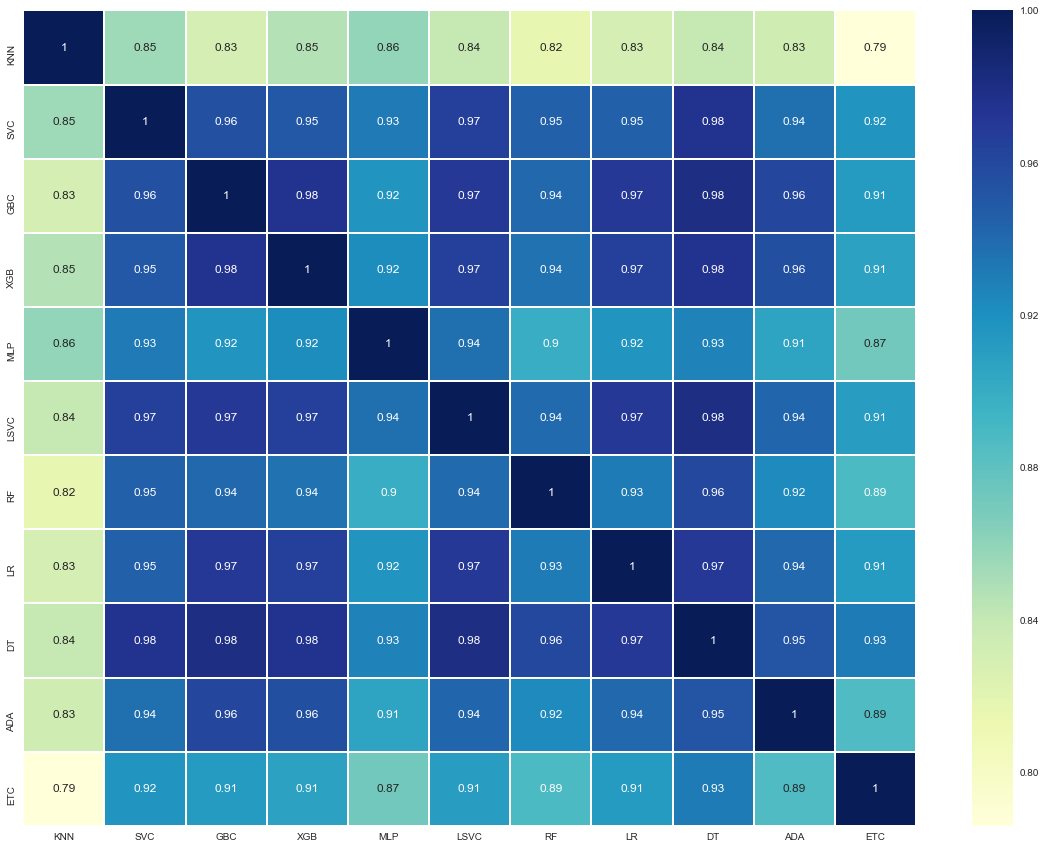

In [95]:
# First thing I want to do, is compare how similarly each of the optimised estimators predict the test dataset.
# I'll do this by creating "columns" using pd.Series to concatenate together
knn_ensemble = pd.Series(gsKNN.predict(etc_reduced_final_test), name = "KNN")
svc_ensemble = pd.Series(gsSVC.predict(etc_reduced_final_test), name = "SVC")
gbc_ensemble = pd.Series(gsGBC.predict(gbc_final_test), name = "GBC")
xgb_ensemble = pd.Series(gsXGB.predict(xgb_final_test), name = "XGB")
mlp_ensemble = pd.Series(gsMLP.predict(etc_reduced_final_test), name = "MLP")
lsvc_ensemble = pd.Series(gsLSVC.predict(etc_reduced_final_test), name = "LSVC")
rf_ensemble = pd.Series(gsRF.predict(rf_rfecv_final_test), name = "RF")
lr_ensemble = pd.Series(gsLR.predict(etc_reduced_final_test), name = "LR")
dt_ensemble = pd.Series(gsDT.predict(dt_final_test), name = "DT")
ada_ensemble = pd.Series(gsADA.predict(ada_rfecv_final_test), name = "ADA")
etc_ensemble = pd.Series(gsETC.predict(etc_rfecv_final_test), name = "ETC")

# Concatenate all classifier results
ensemble_results = pd.concat([knn_ensemble, svc_ensemble, gbc_ensemble, xgb_ensemble, 
                              mlp_ensemble, lsvc_ensemble, rf_ensemble, 
                              lr_ensemble, dt_ensemble, ada_ensemble, etc_ensemble], axis=1)


plt.subplots(figsize=(20, 15))
g= sns.heatmap(ensemble_results.corr(),annot=True, cmap = "YlGnBu", linewidths = 1.0)

- 从这个热图我们可以看到很多估计器有非常高的相关性，表明**预测的结果非常相似**。
- 但是，我们确实有一些模型显示出一些差异。
- 这是我们想要的，因此我现在将继续并建立一个投票合奏。 **然后我将使用35列**将此模型拟合到原始数据集。
     - 我之所以这样做是因为**优化模型都使用不同的数据集，具有不同的大小**。
     - 为了使投票集合起作用，**我们需要将模型放在一个功能集和一个目标功能**上。
     - 因此，我选择了**原始评估和确认集**来对训练数据进行评分并输出测试准确度。
    
**注意**：我将从此投票分类器中排除线性支持向量机。原因是因为我在优化后从高度校准的模型创建投票集合。因此，“软”投票是最合适的。软投票需要输出概率，而LSVC不能产生概率。

In [96]:
# Set up the voting classifier with all of the optimised models I have built.
votingC = VotingClassifier(estimators=[('KNN', KNN_best), ('SVC', SVC_best),('GBC', GBC_best),
                                       ('XGB', XGB_best), ('MLP', MLP_best), ('RF', RF_best), 
                                       ('LR', LR_best), ('DT', DT_best), ('ADA', ADA_best), 
                                       ('ETC', ETC_best)], voting='soft', n_jobs=4)

# Fit the model to the training data
votingC = votingC.fit(X_train, Y_train)

# Take the cross validated training scores as an average
votingC_scores = cross_val_score(votingC, X_train, Y_train, cv = shuff)
votingC_scores = votingC_scores.mean()

# Print the results and include how accurately the voting ensemble was able to predict
# the validation dataset
print('Mean Cross Validated Score: {:.2f}'. format(votingC_scores*100))
votingC_apply_acc = metrics.accuracy_score(Y_test, votingC.predict(X_test))
print('Accuracy when applied to Test: {:.2f}'. format(votingC_apply_acc*100))

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Mean Cross Validated Score: 84.83
Accuracy when applied to Test: 82.06


D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 5.7 - 输出预测

- 我们现在处于最后阶段，**将我们的预测输出到CSV文件并上传到Kaggle **。
- 对于每个适合估算数据集的优化模型，**现在我将预测测试数据集**的生存值。
- 然后，我将**将此预测列与我们导入的原始测试数据集中的“PassengerId”**列结合起来。 这些乘客是我们想要预测的生存的418名乘客。
     - 这两列将按照Kaggle的上传要求的要求连接在一起。

In [97]:
# Output predictions into a csv file for Kaggle upload
KNN_test_pred = KNN_best.predict(etc_reduced_final_test)
KNN_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": KNN_test_pred})
# KNN_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('K-Nearest Neighbours predictions uploaded to CSV!')


# Output predictions into a csv file for Kaggle upload
SVC_test_pred = SVC_best.predict(etc_reduced_final_test)
SVC_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": SVC_test_pred})
# SVC_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Support Vector Machine Classifier predictions uploaded to CSV!')


# Output predictions into a csv file for Kaggle upload
GBC_test_pred = GBC_best.predict(gbc_final_test)
GBC_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": GBC_test_pred})
# GBC_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Gradient Boosting Classifier predictions uploaded to CSV!')

# Output predictions into a csv file for Kaggle upload
XGB_test_pred = XGB_best.predict(xgb_final_test)
XGB_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": XGB_test_pred})
# XGB_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('XGBoost predictions uploaded to CSV!')

# Output predictions into a csv file for Kaggle upload
MLP_test_pred = MLP_best.predict(etc_reduced_final_test)
MLP_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": MLP_test_pred})
# MLP_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Multi Layer Perceptron predictions uploaded to CSV!')

# Output predictions into a csv file for Kaggle upload
LSVC_test_pred = LSVC_best.predict(etc_reduced_final_test)
LSVC_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": LSVC_test_pred})
# LSVC_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Linear Support Vector Machine Classifier predictions uploaded to CSV!')

# Output predictions into a csv file for Kaggle upload
RF_test_pred = RF_best.predict(rf_rfecv_final_test)
RF_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": RF_test_pred})
# RF_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Random Forest predictions uploaded to CSV!')

# Output predictions into a csv file for Kaggle upload
LR_test_pred = LR_best.predict(etc_reduced_final_test)
LR_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": LR_test_pred})
# LR_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Logistic Regression predictions uploaded to CSV!')

# Output predictions into a csv file for Kaggle upload
DT_test_pred = DT_best.predict(dt_final_test)
DT_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": DT_test_pred})
# DT_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Decision Tree predictions uploaded to CSV!')

# Output predictions into a csv file for Kaggle upload
ADA_test_pred = ADA_best.predict(ada_rfecv_final_test)
ADA_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": ADA_test_pred})
# ADA_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Adaboost predictions uploaded to CSV!')

# Extra Trees
ETC_test_pred = ETC_best.predict(etc_rfecv_final_test)
ETC_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": ETC_test_pred})
# ETC_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Extra Trees predictions uploaded to CSV!')

# Voting
votingC_test_pred = votingC.predict(test)
votingC_submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"], "Survived": votingC_test_pred})
# votingC_submission.to_csv('[enter your directory here]', index=False)

print('-'*50)
print('Voting predictions uploaded to CSV!')

print('-'*50)
print("Here's a preview of what the CSV looks like...")
votingC_submission.head()

--------------------------------------------------
K-Nearest Neighbours predictions uploaded to CSV!
--------------------------------------------------
Support Vector Machine Classifier predictions uploaded to CSV!
--------------------------------------------------
Gradient Boosting Classifier predictions uploaded to CSV!
--------------------------------------------------
XGBoost predictions uploaded to CSV!
--------------------------------------------------
Multi Layer Perceptron predictions uploaded to CSV!
--------------------------------------------------
Linear Support Vector Machine Classifier predictions uploaded to CSV!
--------------------------------------------------
Random Forest predictions uploaded to CSV!
--------------------------------------------------
Logistic Regression predictions uploaded to CSV!
--------------------------------------------------
Decision Tree predictions uploaded to CSV!
--------------------------------------------------
Adaboost predictions uplo

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--------------------------------------------------
Voting predictions uploaded to CSV!
--------------------------------------------------
Here's a preview of what the CSV looks like...


D:\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


- 最后要做的只是**将CSV文件上传到Kaggle比赛！**我建议上传一些表现最出色的结果，然后回到代码，迭代以改进它们！
- 这种改进的循环可以永无止境......由你决定什么时候停止。

***

# 6
## 结论

- 在整个过程中，我们已经**彻底地探索了数据**和**进行了各种测试**和实验，以便对其进行充分理解以进行准确的预测。
- 我创作的目的是**分享我的见解**，**向您展示我的工作流程**。 我希望这对你有帮助！
- **使用数据科学，有多种方法可以完成任何任务**。 这只是我的解决方案和我的想法。 **我很想听听你如何做不同的事情，或者我可以如何改进**。

### ***如果你喜欢它，请留下评论，关注我，并upvote！***